<a href="https://colab.research.google.com/github/mnrazamohamed/Airline-Passenger-Satisfaction/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Define

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


## DataHandler

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataHandler:
    def __init__(self, dataset_path):
        """
        Initialize the DataHandler class with the path to the dataset.
        """
        self.dataset_path = dataset_path
        self.data = None
        self.categorical_columns = set()
        self.numerical_columns = set()

    def load_data(self,encoding=None):
        """
        Loads the dataset into a DataFrame.
        """
        try:
            self.data = pd.read_csv(self.dataset_path) if encoding is None else pd.read_csv(self.dataset_path,encoding=encoding)
            print("Dataset loaded successfully!")
        except FileNotFoundError as e:
            print(f"Error: {e}. Please provide the correct file path.")
        return self.data

    def set_categorical_columns(self, categorical_columns):
        """
        Sets the list of categorical columns.
        """
        self.categorical_columns = set(categorical_columns)

    def set_numerical_columns(self, numerical_columns):
        """
        Sets the list of Numerical columns.
        """
        self.numerical_columns = set(numerical_columns)

    def get_categorical_columns(self):
        """
        Returns the list of categorical columns.
        """
        return list(self.categorical_columns)

    def get_numerical_columns(self):
        """
        Returns the list of numerical columns.
        """
        return list(self.numerical_columns)

    def drop_na_rows(self):
        """
        Drops rows with missing values from the dataset.
        """
        print("Dropping rows with missing values...")
        self.data.dropna(inplace=True)

    def drop_columns(self, columns):
        """
        Drops specified columns from the dataset.
        """
        print(f"Dropping columns: {columns}")
        self.data.drop(columns, axis=1, inplace=True)

    def encode_data(self, data_map):
        """
        Encodes categorical variables into numerical values.
        """
        print("Encoding categorical variables...")
        self.data_map = data_map
        self.data.replace(data_map, inplace=True)

    def find_outliers_below_one_percent_and_llul(self, most_value_count, col):
        """
        Identifies outliers using IQR and filters values below 1% frequency.
        """
        a = self.data[col].value_counts()[self.data[col].value_counts() < (most_value_count / 100)]

        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1

        ll = Q1 - 1.5 * IQR  # Lower limit
        ul = Q3 + 1.5 * IQR  # Upper limit

        # Filter values that are either below the lower limit or above the upper limit
        a = a[(a.index > ul) | (a.index < ll)]
        return (col, a.index.to_list(), ll, ul)

    def cap_values_all(self, col_value_pairs):
        """
        Caps the values in the columns to limit outliers.
        """
        print(col_value_pairs)
        for col, values, ll, ul in col_value_pairs:
            self.data[col] = self.data[col].clip(lower=ll, upper=ul)
        return self.data

    def outlier_founder(self):
        """
        Identifies and handles outliers for numerical columns.
        """

        outliers = []
        for col in self.numerical_columns:
            index = self.data[col].value_counts().index[0]
            value = self.data[col].value_counts()[index]
            outliers.append(self.find_outliers_below_one_percent_and_llul(value, col))
        return outliers

    def handle_outliers(self, cap=False, all=False, column=None):
        """
        Detects and caps outliers in the dataset.
        """
        print("Detecting outliers...")
        outliers = self.outlier_founder()
        if cap:
          if all:
            print("Capping outliers...")
            self.data = self.cap_values_all(outliers)
          else:
            print(f"{column} Capping outliers...")
            for c in outliers:
              if c[0] == column:
                self.data = self.cap_values_all([c])
        print(outliers)


    def split_data(self, class_variable, test_size=0.2, random_state=42):
        """
        Splits the dataset into training and testing sets.
        """
        x = self.data.drop(class_variable, axis=1)
        y = self.data[class_variable]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=random_state)
        print("Data split into train and test sets.")
        return x_train, x_test, y_train, y_test

    def balance_classes(self, x_train, y_train, random_state=123):
        """
        Balances the classes in the training data using RandomOverSampler.
        """
        ros = RandomOverSampler(random_state=random_state)
        x_res, y_res = ros.fit_resample(x_train, y_train)

        print('Before oversample:', sum(y_train == 1), sum(y_train == 0))
        print('After oversample:', sum(y_res == 1), sum(y_res == 0))

        return x_res, y_res

    def get_data(self):
        """
        Returns the processed dataset.
        """
        return self.data

    def add_log_column(self, column_name):
        """
        Adds log column to the dataset.
        """
        if column_name not in self.data.columns:
            print(f"Column '{column_name}' not found in DataFrame.")

        # Check for zero or negative values
        if (self.data[column_name] <= 0).any():
            print(f"Column '{column_name}' contains zero or negative values. Cannot compute logarithm.")

        # Add log column
        new_column_name = f"log_{column_name}"
        self.data[new_column_name] = np.log(self.data[column_name])




## EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from scipy.stats import pearsonr, f_oneway


class EDA:
    def __init__(self, data):
        """
        Initialize the EDA class with the dataset.
        """
        self.data = data

    def display_data(self, num_rows=5):
        """Displays the first few rows of the dataset."""
        print(f"First {num_rows} rows of the dataset:")
        return self.data.head(num_rows)

    def display_columns(self):
        """Displays the column names of the dataset."""
        print("Column names:")
        print(self.data.columns.tolist())

    def display_shape(self):
        """Displays the shape of the dataset."""
        print(f"Dataset shape: {self.data.shape}")

    def check_data_types(self):
        """Displays the data types of each column."""
        print("\nData Types:")
        return self.data.dtypes

    def check_missing_values(self):
        """Displays the count of missing values per column."""
        print("\nMissing Values in Each Column:")
        return self.data.isna().sum()

    def check_duplicates(self,unique_cols=None):
        """Checks for duplicate rows based on Loan_ID."""
        if unique_cols is None:
          duplicates = self.data[self.data.duplicated(keep=False)]
        else:
          duplicates = self.data[self.data.duplicated(subset=unique_cols, keep=False)]
        print(f"\nNumber of duplicate entries: {len(duplicates)}")
        if len(duplicates) > 0:
            print(duplicates)

    def catfeature_distribution(self,target):
        """Displays the count and percentage of satisfaction statuses."""
        print("\nsatisfaction Status Distribution:")
        print(self.data[target].value_counts())

        print("\nsatisfaction Status Distribution (%):")
        print(self.data[target].value_counts(normalize=True) * 100)

    def describe_data(self):
        """Generates summary statistics for numerical columns."""
        print("\nSummary Statistics:")
        return self.data.describe()

    def plot_bar_plot(self, column_name):
        """
        Generates a bar (count) plot for a single categorical column.

        Args:
            column_name (str): The name of the categorical column to plot.
        """
        plt.figure(figsize=(8, 4))
        sns.countplot(x=self.data[column_name])
        plt.title(f"Bar Plot of '{column_name}'")
        plt.xlabel(column_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)  # Rotate labels if needed
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self, column=None):
        if column:
          if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in the dataset.")

          # Compute correlations with the specific column
          correlations = self.data.corr()[[column]].sort_values(by=column, ascending=False)

          # Plot the correlation heatmap
          plt.figure(figsize=(8, len(correlations) // 2))
          sns.heatmap(correlations, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
          plt.title(f"Correlation Heatmap: {column} vs Other Columns")
          plt.show()
        else:
            cor = self.data.corr()
            plt.figure(figsize=(18, 8))
            sns.heatmap(cor, annot=True, fmt='.2f')
            plt.title("Correlation Heatmap")
            print(plt.show())

            cor = self.data.corr()
            cor = round(cor, 2)
            cor = cor[cor == 0]
            sns.heatmap(cor, annot=True, fmt='.2f')
            plt.title("Correlation Heatmap")
            print(plt.show())


    def plot_histogram(self, column_name):
        """
        Generates a histogram for a single numerical column.

        Args:
            column_name (str): The name of the numerical column to plot.
        """
        plt.figure(figsize=(8, 4))
        sns.histplot(self.data[column_name], kde=True)
        plt.title(f"Histogram of '{column_name}'")
        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    def plot_boxplot(self, column_name):
        """
        Generates a boxplot for a single numerical column.

        Args:
            column_name (str): The name of the numerical column to plot.
        """
        plt.figure(figsize=(4, 6))
        sns.boxplot(y=self.data[column_name])
        plt.title(f"Boxplot of '{column_name}'")
        plt.ylabel(column_name)
        plt.tight_layout()
        plt.show()

    def plot_violinplot(self, column_name):
        """
        Generates a violinplot for a single numerical column.

        Args:
            column_name (str): The name of the numerical column to plot.
        """
        plt.figure(figsize=(4, 6))
        sns.violinplot(y=self.data[column_name])
        plt.title(f"Violinplot of '{column_name}'")
        plt.ylabel(column_name)

        plt.tight_layout()
        plt.show()


    def pearson_anova_numerical(self, target_col):
        """
        Perform hypothesis testing between the target column (continuous numerical)
        and all other columns (numerical and encoded categorical).

        Parameters:
            target_col (str): The target column name (continuous numerical).

        Returns:
            DataFrame: Results of the hypothesis tests (test statistic, p-values, and significance).
        """
        if target_col not in self.data.columns:
            raise ValueError("Target column not found in the dataset.")

        results = []
        for col in self.data.columns:
            if col == target_col:
                continue

            if len(self.data[col].unique()) < 10:  # Assumes <10 unique values indicates encoded categorical
                # Perform ANOVA for encoded categorical columns
                groups = [group[target_col].dropna() for _, group in self.data.groupby(col)]
                stat, p_value = f_oneway(*groups)
                test_type = "ANOVA"
            else:
                # Perform Pearson correlation for numerical columns
                stat, p_value = pearsonr(self.data[target_col].dropna(), self.data[col].dropna())
                test_type = "Pearson Correlation"

            results.append({
                'Feature': col,
                'Test Type': test_type,
                'Test Statistic': stat,
                'P-value': p_value,
                'Significant': p_value < 0.05
            })

        return pd.DataFrame(results)

    def chi_square_categorical(self, target_col):
        """
        Perform Chi-square tests between the target column and all other categorical columns.

        Parameters:
            target_col (str): The target column name.

        Returns:
            DataFrame: Results of the Chi-square tests (p-values and decisions).
        """

        if target_col not in self.data.columns:
            raise ValueError("Target column not found in dataset.")

        results = []
        for col in data_handler.get_categorical_columns():
            if col == target_col:
                continue

            # Create contingency table
            contingency_table = pd.crosstab(self.data[col], self.data[target_col])

            # Perform Chi-square test
            stat, p_value, _, _ = chi2_contingency(contingency_table)
            results.append({
                'Feature': col,
                'Chi-square statistic': stat,
                'P-value': p_value,
                'Significant': p_value < 0.05
            })

        return pd.DataFrame(results)


## Eval Manager

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Classification metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# Regression metrics
from sklearn.metrics import mean_squared_error, r2_score

# Clustering metrics
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score,
    davies_bouldin_score
)

class EvaluationManager:
    def __init__(self):
        """
        Initialize the EvaluationManager with an empty dictionary for model scores.
        Each entry in self.model_scores will be: model_name -> dict_of_metrics
        """
        self.model_scores = {}

    # ---------------------------------------------------------------------
    # 1. Classification: scoring and confusion matrix
    # ---------------------------------------------------------------------
    def get_conf_matrix(self, y_test, y_pred):
        """
        Computes and returns the confusion matrix as a formatted string.
        """
        conf_matrix = confusion_matrix(y_test, y_pred)
        if conf_matrix.shape == (2, 2):
            # Binary classification case
            TN = conf_matrix[0, 0]
            FP = conf_matrix[0, 1]
            FN = conf_matrix[1, 0]
            TP = conf_matrix[1, 1]

            return f"""
                    Predicted
                    0       1
              0    {TN}      {FP}
      Actual  1    {FN}      {TP}
            """
        else:
            # For multi-class classification, return the raw matrix
            return f"Confusion Matrix:\n{conf_matrix}"

    def get_classification_scores(self, model, X_train, y_train, X_test, y_test):
        """
        Computes classification metrics for the given model.
        """
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)
        accuracy_diff = train_accuracy - test_accuracy

        precision = precision_score(y_test, test_pred, average='macro')
        recall = recall_score(y_test, test_pred, average='macro')
        f1 = f1_score(y_test, test_pred, average='macro')

        return {
            "task_type": "classification",
            "train_accuracy": train_accuracy,
            "val_accuracy": test_accuracy,
            "accuracy_diff": accuracy_diff,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_score": self.get_conf_matrix(y_test, test_pred)
        }

    # ---------------------------------------------------------------------
    # 2. Regression: scoring
    # ---------------------------------------------------------------------
    def get_regression_scores(self, model, X_train, y_train, X_test, y_test):
        """
        Computes regression metrics for the given model.
        """
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        train_mse = mean_squared_error(y_train, train_preds)
        test_mse = mean_squared_error(y_test, test_preds)

        train_r2 = r2_score(y_train, train_preds)
        test_r2 = r2_score(y_test, test_preds)

        return {
            "task_type": "regression",
            "train_mse": train_mse,
            "test_mse": test_mse,
            "train_r2": train_r2,
            "test_r2": test_r2
        }

    # ---------------------------------------------------------------------
    # 3. Clustering: scoring
    # ---------------------------------------------------------------------
    def get_clustering_scores(self, model, X_test, y_test=None):
        """
        Computes clustering metrics for the given model.
        If y_test is provided, you can optionally compute external metrics
        like adjusted_rand_score. Otherwise, we only compute internal metrics.
        """
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # suppress potential warnings

            # Some clustering models do not provide .predict()
            try:
                predicted_labels = model.predict(X_test)
            except:
                predicted_labels = getattr(model, 'labels_', None)

            if predicted_labels is None:
                return {
                    "task_type": "clustering",
                    "silhouette_score": None,
                    "calinski_harabasz_score": None,
                    "davies_bouldin_score": None
                }

            unique_labels = np.unique(predicted_labels)
            if len(unique_labels) < 2:
                # Single cluster or no valid clusters
                return {
                    "task_type": "clustering",
                    "silhouette_score": None,
                    "calinski_harabasz_score": None,
                    "davies_bouldin_score": None
                }

            # Internal clustering metrics
            silhouette = silhouette_score(X_test, predicted_labels)
            calinski = calinski_harabasz_score(X_test, predicted_labels)
            davies = davies_bouldin_score(X_test, predicted_labels)

            # Optionally, if you have y_test for external metrics:
            # from sklearn.metrics import adjusted_rand_score
            # ari = adjusted_rand_score(y_test, predicted_labels)

            return {
                "task_type": "clustering",
                "silhouette_score": silhouette,
                "calinski_harabasz_score": calinski,
                "davies_bouldin_score": davies
                # "adjusted_rand_score": ari  # if you want external
            }

    # ---------------------------------------------------------------------
    # 4. Unified reporting
    # ---------------------------------------------------------------------
    def print_evaluation_report(self, model_name, info):
        """
        Prints the metrics contained in `info` dictionary.
        Uses 'task_type' to determine which metrics to print.
        """
        task_type = info.get("task_type", "unknown")
        print(f"\n===========================")
        print(f" Evaluation for: {model_name}")
        print(f"===========================")

        if task_type == "classification":
            print(f"Training Accuracy  : {info['train_accuracy']:.4f}")
            print(f"Validation Accuracy: {info['val_accuracy']:.4f}")
            print(f"Accuracy Difference: {info['accuracy_diff']:.4f}")
            print(f"Precision          : {info['precision']:.4f}")
            print(f"Recall             : {info['recall']:.4f}")
            print(f"F1 Score           : {info['f1']:.4f}\n")

            if 'confusion_score' in info:
                print("Confusion Matrix")
                print(info['confusion_score'])

        elif task_type == "regression":
            print(f"Train MSE : {info['train_mse']:.4f}")
            print(f"Val MSE   : {info['val_mse']:.4f}")
            print(f"MSE diff  : {info['mse_diff']:.4f}\n")

            print(f"Train MAE : {info['train_mae']:.4f}")
            print(f"Val MAE   : {info['val_mae']:.4f}")
            print(f"MAE diff  : {info['mae_diff']:.4f}\n")

            print(f"Train R^2 : {info['train_r2']:.4f}")
            print(f"Val R^2   : {info['val_r2']:.4f}")
            print(f"R^2 diff  : {info['r2_diff']:.4f}\n")


        elif task_type == "clustering":
            print(f"Silhouette Score        : {info['silhouette_score']}")
            print(f"Calinski-Harabasz Score: {info['calinski_harabasz_score']}")
            print(f"Davies-Bouldin Score    : {info['davies_bouldin_score']}\n")

        else:
            print("Unknown task type. No specific metrics to show.")

        # Optionally plot metrics if classification or regression:
        if task_type in ("classification", "regression"):
            self.plot_performance_metrics(model_name, info)

    # ---------------------------------------------------------------------
    # 5. Plotting utilities
    # ---------------------------------------------------------------------
    def plot_performance_metrics(self, model_name, info):
        """
        Plots a bar chart of the performance metrics for classification or regression.
        """
        task_type = info.get("task_type", None)

        if task_type == "classification":
            metrics = [
                ('Training Accuracy', info['train_accuracy']),
                ('Validation Accuracy', info['val_accuracy']),
                ('Accuracy Difference', info['accuracy_diff']),
                ('Precision', info['precision']),
                ('Recall', info['recall']),
                ('F1 Score', info['f1'])
            ]
            self._plot_bar_chart(model_name, metrics)

        elif task_type == "regression":
              metrics = [
                  ('Train MSE', info['train_mse']),
                  ('Val MSE', info['val_mse']),
                  ('MSE diff', info['mse_diff']),
                  ('Train MAE', info['train_mae']),
                  ('Val MAE', info['val_mae']),
                  ('MAE diff', info['mae_diff']),
                  ('Train R^2', info['train_r2']),
                  ('Val R^2', info['val_r2']),
                  ('R^2 diff', info['r2_diff']),
              ]

              self._plot_bar_chart(model_name, metrics)

        else:
            # For clustering (or unknown), we skip bar chart,
            # or you can implement a scatter plot, elbow plot, etc. if desired.
            pass

    def _plot_bar_chart(self, model_name, metrics):
        """
        Helper method to plot a generic bar chart given a list of (label, value) pairs.
        """
        labels = [m[0] for m in metrics]
        values = [m[1] for m in metrics]

        plt.figure(figsize=(8, 5))
        bars = plt.bar(labels, values, color='skyblue')
        plt.title(f'{model_name} Performance Metrics')

        # Adjust the Y-axis range if it makes sense for your metrics
        # If some values can be negative (e.g., R^2 in certain cases), handle that accordingly
        if all(v >= 0 for v in values):
            plt.ylim(0, max(values)*1.1)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, height,
                     f"{height:.4f}", ha='center', va='bottom', fontsize=9)

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # ---------------------------------------------------------------------
    # 6. Plot comparison across multiple models
    # ---------------------------------------------------------------------
    def plot_model_metric_comparison(self, metric):
        """
        Plots a bar chart comparing a specific metric across models.
        Example usage: self.plot_model_metric_comparison('val_accuracy')
        """
        # Extract metric values from self.model_scores where metric exists
        metric_values = {
            model: scores[metric]
            for model, scores in self.model_scores.items()
            if metric in scores
        }

        if not metric_values:
            print(f"No metric '{metric}' found in any of the stored models.")
            return

        diff_metrics = ['accuracy_diff', 'mse_diff', 'mae_diff', 'r2_diff']

        if metric in diff_metrics:
            # For difference metrics, we want the smallest absolute value to be the best
            abs_diff_values = {m: abs(v) for m, v in metric_values.items()}
            best_model = min(abs_diff_values, key=abs_diff_values.get)
            colors = ['green' if model == best_model else 'skyblue' for model in metric_values]
        else:
            # For "standard" metrics, the higher the better (e.g., accuracy, precision, recall, R^2)
            # or if it's MSE or MAE (which is not in diff_metrics), you might want the smallest as best.
            # Adjust accordingly if you want MSE or MAE to highlight "lowest" as best.

            # Example: highest is best for accuracy, precision, recall, f1, r2
            # but *lowest* is best for MSE, MAE.
            # So we might do a separate check if metric in ['train_mse','val_mse','train_mae','val_mae'].

            if metric in ['train_mse','val_mse','train_mae','val_mae']:
                # highlight the minimum
                best_model = min(metric_values, key=metric_values.get)
            else:
                # highlight the maximum
                best_model = max(metric_values, key=metric_values.get)

            colors = ['green' if model == best_model else 'skyblue' for model in metric_values]


        plt.figure(figsize=(8, 3))
        plt.bar(metric_values.keys(), metric_values.values(), color=colors)
        plt.title(f'{metric} Comparison')
        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_all_metrics(self):
        """
        Plots bar charts for multiple metrics across all models (classification/regression).
        For clustering metrics, you can implement a separate approach if you like.
        """
        # Common classification/regression metrics you want to compare:
        # (You can add or remove any metrics here)
        candidate_metrics = [
            # Classification metrics
            'train_accuracy', 'val_accuracy', 'accuracy_diff',
            'precision', 'recall', 'f1',

            # Regression metrics
            'train_mse', 'val_mse', 'mse_diff',
            'train_mae', 'val_mae', 'mae_diff',
            'train_r2', 'val_r2', 'r2_diff',
        ]
        for metric in candidate_metrics:
            # Only plot if at least one model has this metric
            if any(metric in scores for scores in self.model_scores.values()):
                print(f"Plotting {metric} comparison...")
                self.plot_model_metric_comparison(metric)


In [ ]:
!pip install optuna


## Tune manager

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from optuna.visualization import (
    plot_optimization_history,
    plot_slice,
    plot_parallel_coordinate,
    plot_param_importances,
    plot_contour
)

class TuningManager:
    def __init__(self, models):

        self.models = models

    def classification_objective(self,trial):
        # Suggest hyperparameters for each base estimator
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 1000, step=100)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 10)
        xgb_lr = trial.suggest_float('xgb_lr', 1e-3, 1e-1, log=True)

        lgbm_n_estimators = trial.suggest_int('lgbm_n_estimators', 100, 1000, step=100)
        lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 31, 127)

        catb_depth = trial.suggest_int('catb_depth', 4, 10)
        catb_iters = trial.suggest_int('catb_iters', 100, 1000, step=100)

        # Optionally tune voting weights
        w1 = trial.suggest_float('weight_xgb', 0.5, 2.0)
        w2 = trial.suggest_float('weight_lgbm', 0.5, 2.0)
        w3 = trial.suggest_float('weight_catb', 0.5, 2.0)

        # Build estimators with suggested params
        xgb =  self.models['XGBoost']
        xgb.set_params(n_estimators=xgb_n_estimators,
                      max_depth=xgb_max_depth,
                      learning_rate=xgb_lr)

        lgbm =  self.models['LightGBM']
        lgbm.set_params(n_estimators=lgbm_n_estimators,
                        num_leaves=lgbm_num_leaves)

        catb =  self.models['CatBoost']
        catb.set_params(depth=catb_depth, iterations=catb_iters)

        # VotingClassifier
        hard_voting = VotingClassifier(
            estimators=[('XGBoost', xgb), ('LightGBM', lgbm), ('CatBoost', catb)],
            voting='hard',
            weights=[w1, w2, w3]
        )

        # Evaluate via cross-validation
        scores = cross_val_score(hard_voting, x_train, y_train, cv=5, scoring='f1')
        return scores.mean()

    def tune_hard_voting_classification(self,trials = 50):
      study = optuna.create_study(direction='maximize',study_name='hard_voting_tuner')
      study.optimize(self.classification_objective, n_trials=trials)
      return study

    def create_best_hard_vote_classification(self,best_params):

      # Extract XGBoost params
      xgb_n_estimators = best_params['xgb_n_estimators']
      xgb_max_depth    = best_params['xgb_max_depth']
      xgb_lr           = best_params['xgb_lr']

      # Extract LightGBM params
      lgbm_n_estimators = best_params['lgbm_n_estimators']
      lgbm_num_leaves   = best_params['lgbm_num_leaves']

      # Extract CatBoost params
      catb_depth       = best_params['catb_depth']
      catb_iters       = best_params['catb_iters']

      # Extract Voting Weights
      w1 = best_params['weight_xgb']
      w2 = best_params['weight_lgbm']
      w3 = best_params['weight_catb']

      # Instantiate models with the tuned parameters
      xgb_clf =  self.models['XGBoost']
      xgb_clf.set_params(
          n_estimators=xgb_n_estimators,
          max_depth=xgb_max_depth,
          learning_rate=xgb_lr
      )

      lgbm_clf =  self.models['LightGBM']
      lgbm_clf.set_params(
          n_estimators=lgbm_n_estimators,
          num_leaves=lgbm_num_leaves
      )

      catb_clf =  self.models['CatBoost']
      catb_clf.set_params(
          depth=catb_depth,
          iterations=catb_iters
      )

      # Build the final ensemble with best weights
      hard_voting_best = VotingClassifier(
          estimators=[
              ('XGBoost', xgb_clf),
              ('LightGBM', lgbm_clf),
              ('CatBoost', catb_clf)
          ],
          voting='hard',
          weights=[w1, w2, w3]
      )

      return hard_voting_best

    def plot_study(self, study: optuna.Study):
        """
        Generate and display various plots from an Optuna Study.

        Parameters
        ----------
        study : optuna.Study
            The Optuna Study to visualize.
        """
        # 1. Optimization History
        fig_optimization_history = plot_optimization_history(study)
        fig_optimization_history.show()

        # 2. Parameter Importance (based on completed trials)
        fig_param_importances = plot_param_importances(study)
        fig_param_importances.show()

        # 3. Parallel Coordinate Plot
        fig_parallel_coordinate = plot_parallel_coordinate(study)
        fig_parallel_coordinate.show()

        # 4. Slice Plot
        fig_slice = plot_slice(study)
        fig_slice.show()

        # 5. Contour Plot
        fig_contour = plot_contour(study)
        fig_contour.show()

In [ ]:
!pip install catboost

## Model Manager

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score, mean_absolute_error
)
import numpy as np
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# -------------------------------------------------------------------------
# Main Manager that can handle classification, regression, and clustering
# -------------------------------------------------------------------------
class MultiTaskModelManager(EvaluationManager, TuningManager):
    def __init__(self):
        super().__init__()
        # Dictionary storing model_name -> {"model": model_object, "task": "classification"/"regression"/"clustering"}
        self.models = {}
        self.model_metrics = {}

    def add_model(self, model_name, model, task):
        """
        Adds a model to the manager with a specified task:
          - 'classification'
          - 'regression'
          - 'clustering'
        """
        if task not in ["classification", "regression", "clustering"]:
            raise ValueError("Task must be 'classification', 'regression', or 'clustering'.")
        self.models[model_name] = {
            "model": model,
            "task": task
        }

    def train_model(self, model_name, X_train, y_train=None):
        """
        Trains the specified model.
        For clustering, y_train may be None (unsupervised).
        """
        model_info = self.models.get(model_name)
        if not model_info:
            print(f"Model {model_name} not found.")
            return

        model = model_info["model"]
        task = model_info["task"]

        try:
            if task == "clustering":
                # Clustering typically doesn't use y
                model.fit(X_train)
            else:
                # Classification or regression requires X, y
                model.fit(X_train, y_train)
            print(f"{model_name} ({task}) trained successfully.")
        except Exception as e:
            print(f"Failed to train {model_name}: {str(e)}")

    def predict(self, model_name, X):
        """
        Makes predictions (or cluster assignments) using a trained model.
        For clustering, `predict` gives cluster labels (if supported).
        """
        model_info = self.models.get(model_name)
        if not model_info:
            print(f"Model {model_name} not found.")
            return None

        model = model_info["model"]
        task = model_info["task"]

        try:
            # Some clustering algorithms (like DBSCAN) may not have predict()
            return model.predict(X)
        except Exception as e:
            print(f"Failed to predict using {model_name}: {str(e)}")
            return None

    # ---------------------------------------------------------------------
    # Evaluation
    # ---------------------------------------------------------------------
    def evaluate_model(self, model_name, X_train, y_train, X_test, y_test):
        """
        Evaluates a specific model and prints/stores its metrics.
        For clustering, we rely on unsupervised (internal) metrics,
        or possibly external metrics if y_test is available.
        """
        model_info = self.models.get(model_name)
        if not model_info:
            print(f"Model {model_name} not found.")
            return

        model = model_info["model"]
        task = model_info["task"]

        # If we used K-Fold, we can skip re-evaluating on the holdout set
        # or do a final evaluation on test. We'll just show how to skip
        # if user specifically wants to rely on K-Fold metrics:
        if model_name in self.model_metrics:
            info = self.model_metrics[model_name]
            print(f"Using stored KFold metrics for {model_name} ({task}).")
            self.model_scores[model_name] = info
            info['task_type'] = task
            self.print_evaluation_report(model_name, info)
            return

        # Evaluate based on task
        if task == "classification":
            info = self.evaluate_classification(model, X_train, y_train, X_test, y_test)
            info['confusion_score'] = self.get_conf_matrix(y_test, model.predict(X_test))

        elif task == "regression":
            info = self.evaluate_regression(model, X_train, y_train, X_test, y_test)
        else:  # clustering
            info = self.evaluate_clustering(model, X_test, y_test)

        self.model_scores[model_name] = info
        info['task_type'] = task
        self.print_evaluation_report(model_name, info)

    def evaluate_classification(self, model, X_train, y_train, X_test, y_test):
        """Compute classification metrics."""
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        metrics = {}
        metrics["train_accuracy"] = accuracy_score(y_train, train_preds)
        metrics["test_accuracy"] = accuracy_score(y_test, test_preds)
        metrics["precision"] = precision_score(y_test, test_preds, average='macro')
        metrics["recall"] = recall_score(y_test, test_preds, average='macro')
        metrics["f1"] = f1_score(y_test, test_preds, average='macro')

        return metrics

    def evaluate_regression(self, model, X_train, y_train, X_test, y_test):
        """Compute regression metrics."""
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        metrics = {}
        metrics["train_mse"] = mean_squared_error(y_train, train_preds)
        metrics["test_mse"] = mean_squared_error(y_test, test_preds)
        metrics["train_r2"] = r2_score(y_train, train_preds)
        metrics["test_r2"] = r2_score(y_test, test_preds)
        return metrics

    def evaluate_clustering(self, model, X_test, y_test=None):
        """
        Compute clustering metrics. If you have no labels, we use internal metrics:
          - silhouette score
          - calinski-harabasz score
          - davies-bouldin score
        If you have labels, you can add external metrics (e.g., adjusted_rand_score).
        """
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # suppress potential warnings
            try:
                predicted_labels = model.predict(X_test)
            except:
                # If the model does not support predict(), fallback to model.labels_
                predicted_labels = getattr(model, 'labels_', None)

            metrics = {}
            if predicted_labels is None:
                # If the model doesn't provide labels, skip
                metrics["silhouette_score"] = None
                metrics["calinski_harabasz_score"] = None
                metrics["davies_bouldin_score"] = None
                return metrics

            # Need at least 2 clusters to compute internal metrics
            if len(set(predicted_labels)) > 1:
                metrics["silhouette_score"] = silhouette_score(X_test, predicted_labels)
                metrics["calinski_harabasz_score"] = calinski_harabasz_score(X_test, predicted_labels)
                metrics["davies_bouldin_score"] = davies_bouldin_score(X_test, predicted_labels)
            else:
                metrics["silhouette_score"] = None
                metrics["calinski_harabasz_score"] = None
                metrics["davies_bouldin_score"] = None

            # If you have ground-truth labels for clustering, you can do:
            # from sklearn.metrics import adjusted_rand_score
            # metrics["adjusted_rand_score"] = adjusted_rand_score(y_test, predicted_labels)

            return metrics

    # ---------------------------------------------------------------------
    # K-Fold Training (for Classification & Regression only)
    # ---------------------------------------------------------------------
    def train_model_KFold(self, model_name, X, y, n_splits=5):
        """
        Trains the model using K-fold cross-validation (only for classification & regression).
        For clustering, we skip K-Fold.
        """
        model_info = self.models.get(model_name)
        if not model_info:
            print(f"Model {model_name} not found.")
            return

        model = model_info["model"]
        task = model_info["task"]

        # Skip K-Fold for clustering
        if task == "clustering":
            print(f"K-Fold not applied for clustering model: {model_name}.")
            self.train_model(model_name, X)

            return

        print(f"\n--- K-Fold ({n_splits}) training for {model_name} ({task}) ---")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Accumulators
        train_scores = []
        val_scores = []

        # Additional metrics for classification
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Accumulators for regression
        train_mse_scores = []
        val_mse_scores = []
        train_mae_scores = []
        val_mae_scores = []
        train_r2_scores = []
        val_r2_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]

            # Fit
            model.fit(X_train_fold, y_train_fold)

            # Predictions
            train_preds = model.predict(X_train_fold)
            val_preds = model.predict(X_val_fold)

            if task == "classification":
                train_acc = accuracy_score(y_train_fold, train_preds)
                val_acc = accuracy_score(y_val_fold, val_preds)
                prec = precision_score(y_val_fold, val_preds, average='macro')
                rec = recall_score(y_val_fold, val_preds, average='macro')
                f1 = f1_score(y_val_fold, val_preds, average='macro')

                train_scores.append(train_acc)
                val_scores.append(val_acc)
                precision_scores.append(prec)
                recall_scores.append(rec)
                f1_scores.append(f1)

            elif task == "regression":
                train_mse = mean_squared_error(y_train_fold, train_preds)
                val_mse = mean_squared_error(y_val_fold, val_preds)

                train_mae = mean_absolute_error(y_train_fold, train_preds)
                val_mae = mean_absolute_error(y_val_fold, val_preds)

                # For R^2, you can get train R^2 as well
                train_r2 = r2_score(y_train_fold, train_preds)
                val_r2 = r2_score(y_val_fold, val_preds)

                # Accumulate these fold metrics
                train_mse_scores.append(train_mse)
                val_mse_scores.append(val_mse)

                train_mae_scores.append(train_mae)
                val_mae_scores.append(val_mae)

                train_r2_scores.append(train_r2)
                val_r2_scores.append(val_r2)

        # Refit on entire dataset after CV
        model.fit(X, y)

        # Store aggregated metrics
        info = {}
        if task == "classification":
            info["train_accuracy"] = np.mean(train_scores)
            info["val_accuracy"] = np.mean(val_scores)
            info["accuracy_diff"] = np.mean(train_scores) - np.mean(val_scores)
            info["precision"] = np.mean(precision_scores)
            info["recall"] = np.mean(recall_scores)
            info["f1"] = np.mean(f1_scores)

        elif task == "regression":
            # ----- Regression summary -----
            info["train_mse"] = np.mean(train_mse_scores)
            info["val_mse"]   = np.mean(val_mse_scores)
            info["mse_diff"]  = info["train_mse"] - info["val_mse"]

            info["train_mae"] = np.mean(train_mae_scores)
            info["val_mae"]   = np.mean(val_mae_scores)
            info["mae_diff"]  = info["train_mae"] - info["val_mae"]

            info["train_r2"]  = np.mean(train_r2_scores)
            info["val_r2"]    = np.mean(val_r2_scores)
            info["r2_diff"]   = info["train_r2"] - info["val_r2"]

        self.model_metrics[model_name] = info

    def train_all_models_KFold(self, X, y, n_splits=5):
        """Runs K-Fold training for all classification/regression models."""
        for model_name in self.models:
            self.train_model_KFold(model_name, X, y, n_splits=n_splits)

    def evaluate_all_models(self, X_train, y_train, X_test, y_test):
        """
        Evaluates all models stored in the manager.
        """
        for model_name in self.models:
            print(f"\nEvaluating {model_name}...")
            self.evaluate_model(
                model_name,
                X_train,
                y_train,
                X_test,
                y_test,
            )

    def get_all_models(self):
        """Returns all models stored in the manager."""
        return self.models


# Code Main

In [ ]:
!pip install kaggle

!rm train.csv
!kaggle datasets download --unzip -d teejmahal20/airline-passenger-satisfaction -f train.csv
!unzip train.csv.zip
!rm train.csv.zip

!rm test.csv
!kaggle datasets download --unzip -d teejmahal20/airline-passenger-satisfaction -f test.csv
!unzip test.csv.zip
!rm test.csv.zip


Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/2.17M [00:00<?, ?B/s]
100% 2.17M/2.17M [00:00<00:00, 40.9MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/555k [00:00<?, ?B/s]
100% 555k/555k [00:00<00:00, 49.2MB/s]
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
train_path = 'train.csv'
test_path = 'test.csv'

In [ ]:
data_handler = DataHandler(train_path)

In [ ]:
# Load the data
data = data_handler.load_data()

Dataset loaded successfully!


In [ ]:
# Initialize the EDA class with the dataset
eda = EDA(data)

In [ ]:
# Display first 5 data
eda.display_data(5)

In [ ]:
# display columns
eda.display_columns()

Column names:
['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


In [ ]:
data_handler.drop_columns(['Unnamed: 0','id'])

Dropping columns: ['Unnamed: 0', 'id']


In [ ]:
# display shape
eda.display_shape()

Dataset shape: (103904, 23)


In [ ]:
# display data types
eda.check_data_types()

In [ ]:
data_handler.set_categorical_columns([
    "Gender",
    "Customer Type",
    "Type of Travel",
    "Class",
    "Inflight wifi service",
    "Departure/Arrival time convenient",
    "Ease of Online booking",
    "Gate location",
    "Food and drink",
    "Online boarding",
    "Seat comfort",
    "Inflight entertainment",
    "On-board service",
    "Leg room service",
    "Baggage handling",
    "Checkin service",
    "Inflight service",
    "Cleanliness",
    "satisfaction"
])

In [ ]:
data_handler.set_numerical_columns([
    "Age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
])

In [ ]:
eda.check_missing_values()

## data cleaning

In [ ]:
data_handler.drop_na_rows()

Dropping rows with missing values...


In [ ]:
eda.check_duplicates()


Number of duplicate entries: 0


In [ ]:
eda.catfeature_distribution('satisfaction')


satisfaction Status Distribution:
satisfaction
0    58697
1    44897
Name: count, dtype: int64

satisfaction Status Distribution (%):
satisfaction
0    56.660617
1    43.339383
Name: proportion, dtype: float64


In [ ]:
data['log_DepartureDelayMinutes'] = np.log1p(data['Departure Delay in Minutes'])  # log(1 + x)
data['log_ArrivalDelayMinutes'] = np.log1p(data['Arrival Delay in Minutes'])  # log(1 + x)

data_handler.set_numerical_columns([*data_handler.get_numerical_columns(),'log_DepartureDelayMinutes','log_ArrivalDelayMinutes'])

In [ ]:
for col in data_handler.get_categorical_columns():
    eda.plot_bar_plot(col)

In [ ]:
data_map = {
  "Gender": {"Male": 1, "Female": 0},
  "Customer Type": {"Loyal Customer": 1, "disloyal Customer": 0},
  "Type of Travel": {"Personal Travel": 0, "Business travel": 1},
  "Class": {"Eco Plus": 1, "Business": 2,"Eco": 0},
  "Class": {"Eco Plus": 1, "Business": 2,"Eco": 0},
  "satisfaction": {"neutral or dissatisfied": 0, "satisfied": 1},
}

In [ ]:
data_handler.encode_data(data_map)

Encoding categorical variables...


<ipython-input-198-f08059cd46f1>:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data.replace(data_map, inplace=True)


In [ ]:
eda.plot_correlation_heatmap('satisfaction')

In [ ]:
eda.chi_square_categorical('satisfaction')

In [ ]:
eda.plot_correlation_heatmap('log_ArrivalDelayMinutes')

In [ ]:
eda.pearson_anova_numerical('log_DepartureDelayMinutes')

In [ ]:
for c in data_handler.get_numerical_columns():
    eda.plot_histogram(c)

In [ ]:
data_handler.get_numerical_columns()

['Flight Distance',
 'Departure Delay in Minutes',
 'Age',
 'log_ArrivalDelayMinutes',
 'log_DepartureDelayMinutes',
 'Arrival Delay in Minutes']

In [ ]:
for d in data_handler.get_numerical_columns():
    eda.plot_boxplot(d)

In [ ]:
for c in data_handler.get_numerical_columns():
    eda.plot_violinplot(c)

In [ ]:
# data_handler.handle_outliers(cap=True,column='Flight Distance')

# Problem 1: Satisfiction


In [ ]:
x_train, x_test, y_train, y_test = data_handler.split_data("satisfaction")

Data split into train and test sets.


In [ ]:
x_train, y_train = data_handler.balance_classes(x_train, y_train)

Before oversample: 35833 47042
After oversample: 47042 47042


## Experiment 1 - Baseline Models Without Tuning

In [ ]:
# Initialize the model manager
classification_model_manager = MultiTaskModelManager()

In [ ]:
# Add models to the manager
classification_model_manager.add_model('XGBoost', XGBClassifier(), task='classification')
classification_model_manager.add_model('LightGBM', LGBMClassifier(verbosity=-1), task='classification')
classification_model_manager.add_model('CatBoost', CatBoostClassifier(logging_level='Silent'), task='classification')

In [ ]:
# Train all models
classification_model_manager.train_all_models_KFold(x_train, y_train)


--- K-Fold (5) training for XGBoost (classification) ---

--- K-Fold (5) training for LightGBM (classification) ---

--- K-Fold (5) training for CatBoost (classification) ---



Evaluating XGBoost...
Using stored KFold metrics for XGBoost (classification).

 Evaluation for: XGBoost
Training Accuracy  : 0.9798
Validation Accuracy: 0.9649
Accuracy Difference: 0.0149
Precision          : 0.9650
Recall             : 0.9649
F1 Score           : 0.9649



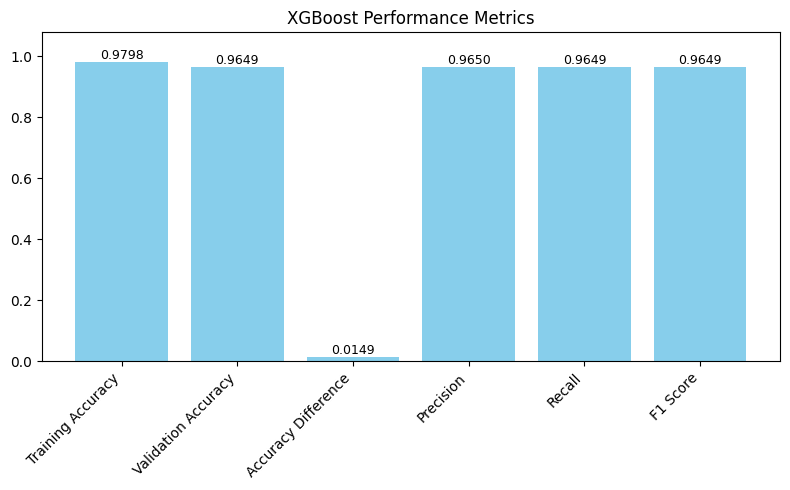


Evaluating LightGBM...
Using stored KFold metrics for LightGBM (classification).

 Evaluation for: LightGBM
Training Accuracy  : 0.9655
Validation Accuracy: 0.9619
Accuracy Difference: 0.0036
Precision          : 0.9622
Recall             : 0.9619
F1 Score           : 0.9619



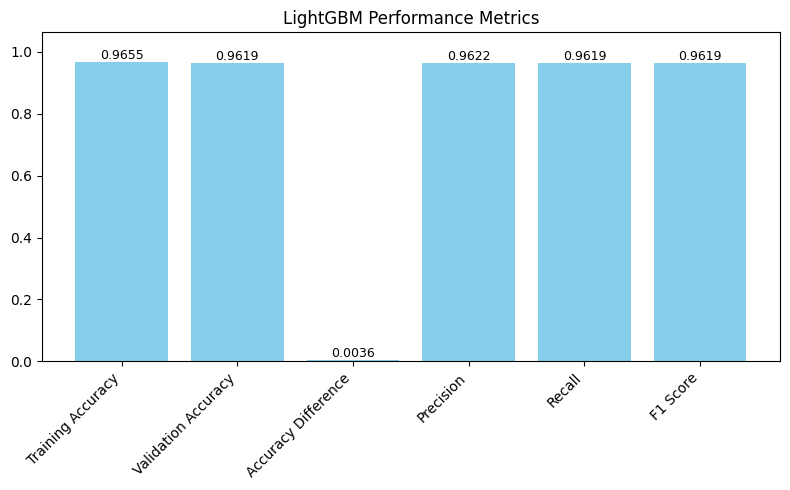


Evaluating CatBoost...
Using stored KFold metrics for CatBoost (classification).

 Evaluation for: CatBoost
Training Accuracy  : 0.9786
Validation Accuracy: 0.9651
Accuracy Difference: 0.0135
Precision          : 0.9653
Recall             : 0.9651
F1 Score           : 0.9651



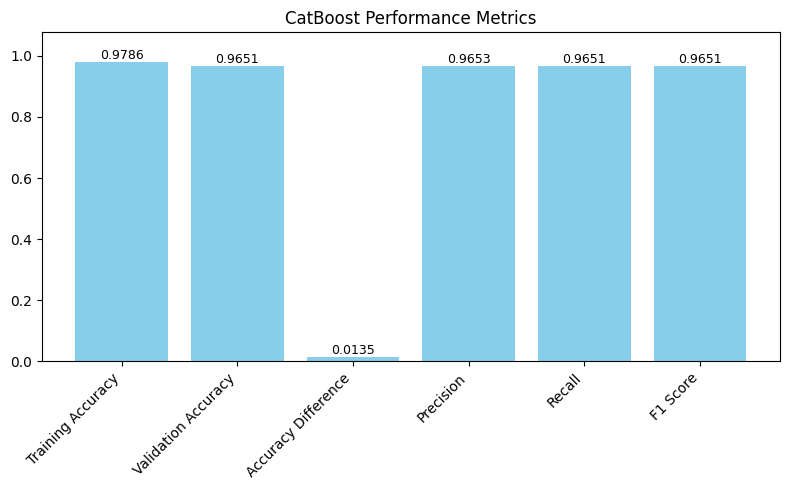

In [ ]:
# Evaluate all models
classification_model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

Plotting train_accuracy comparison...


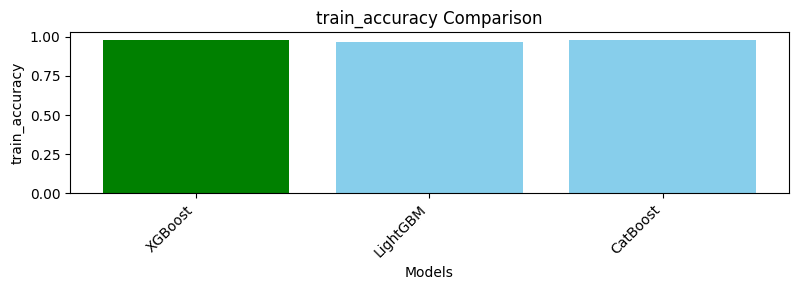

Plotting val_accuracy comparison...


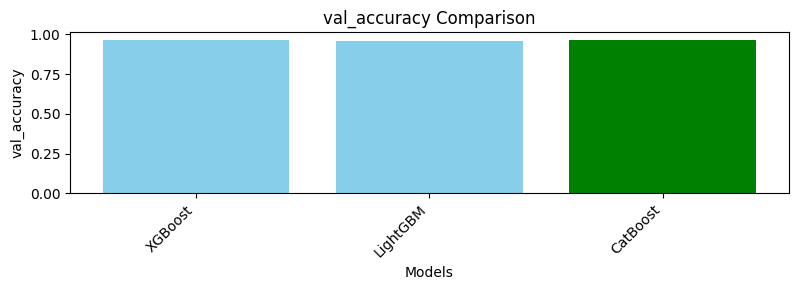

Plotting accuracy_diff comparison...


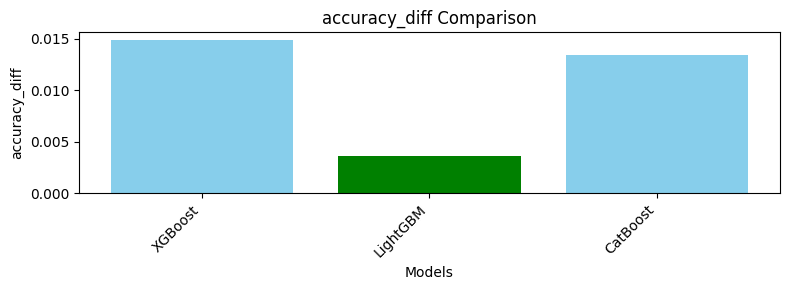

Plotting precision comparison...


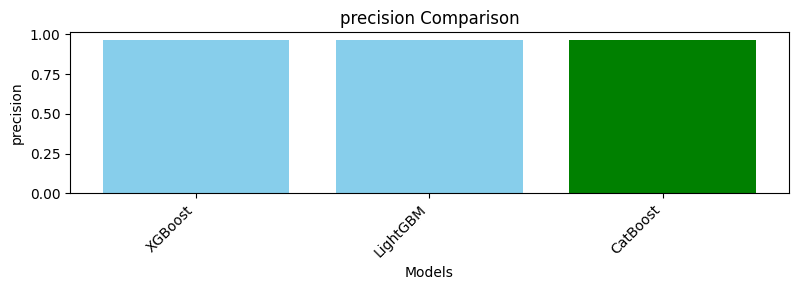

Plotting recall comparison...


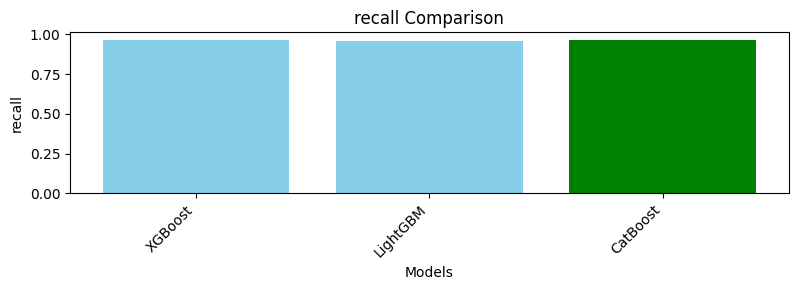

Plotting f1 comparison...


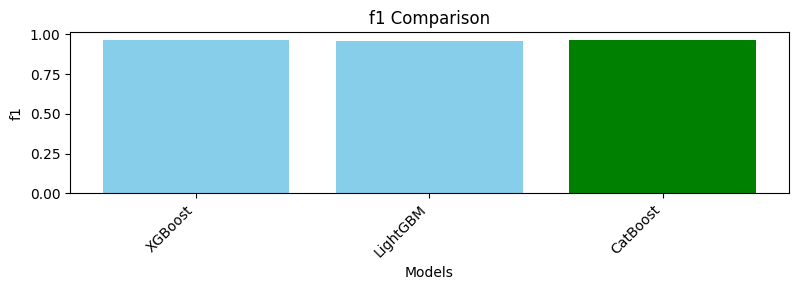

In [ ]:
classification_model_manager.plot_all_metrics()

## Experiment 2: custom ensemble architecture

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

models = [
    ('XGBoost', classification_model_manager.get_all_models()['XGBoost']['model']),
    ('LightGBM', classification_model_manager.get_all_models()['LightGBM']['model']),
    ('CatBoost', classification_model_manager.get_all_models()['CatBoost']['model'])
]
soft_voting = VotingClassifier( estimators=models,  voting='soft'  )
hard_voting = VotingClassifier( estimators=models,  voting='hard'  )
classification_model_manager.add_model('SoftVoting', soft_voting, task='classification')
classification_model_manager.add_model('hardVoting', hard_voting, task='classification')


In [ ]:
# Train all models
classification_model_manager.train_all_models_KFold(x_train, y_train)


--- K-Fold (5) training for XGBoost (classification) ---

--- K-Fold (5) training for LightGBM (classification) ---

--- K-Fold (5) training for CatBoost (classification) ---

--- K-Fold (5) training for SoftVoting (classification) ---

--- K-Fold (5) training for hardVoting (classification) ---



Evaluating XGBoost...
Using stored KFold metrics for XGBoost (classification).

 Evaluation for: XGBoost
Training Accuracy  : 0.9798
Validation Accuracy: 0.9649
Accuracy Difference: 0.0149
Precision          : 0.9650
Recall             : 0.9649
F1 Score           : 0.9649



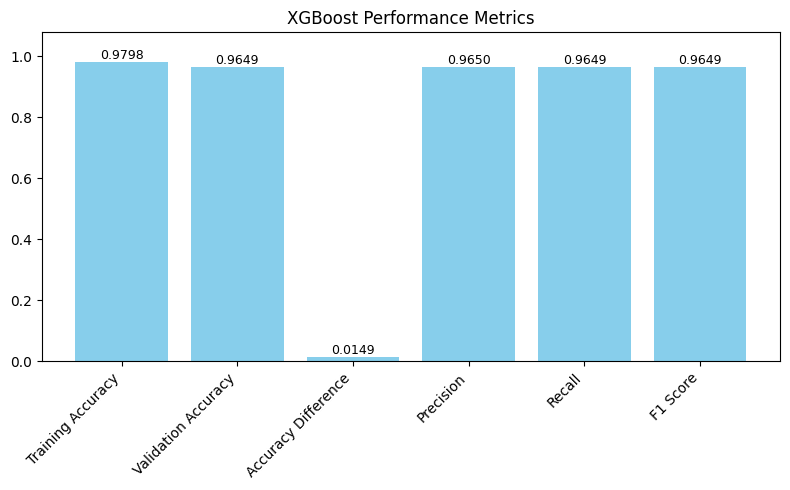


Evaluating LightGBM...
Using stored KFold metrics for LightGBM (classification).

 Evaluation for: LightGBM
Training Accuracy  : 0.9655
Validation Accuracy: 0.9619
Accuracy Difference: 0.0036
Precision          : 0.9622
Recall             : 0.9619
F1 Score           : 0.9619



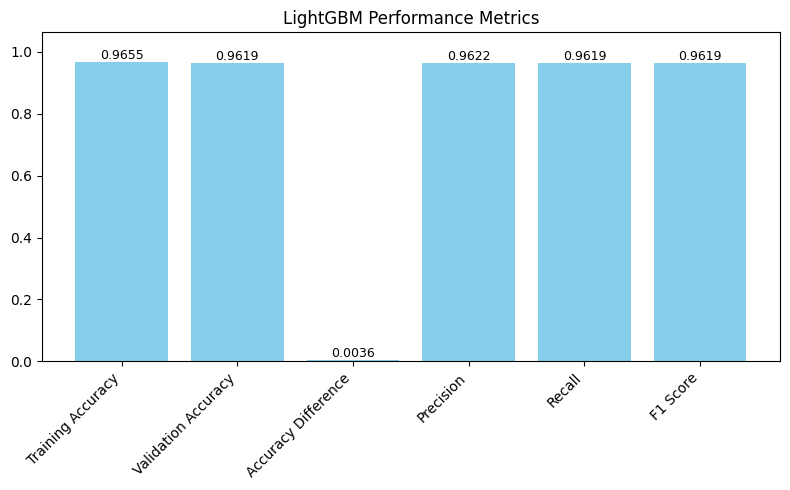


Evaluating CatBoost...
Using stored KFold metrics for CatBoost (classification).

 Evaluation for: CatBoost
Training Accuracy  : 0.9786
Validation Accuracy: 0.9651
Accuracy Difference: 0.0135
Precision          : 0.9653
Recall             : 0.9651
F1 Score           : 0.9651



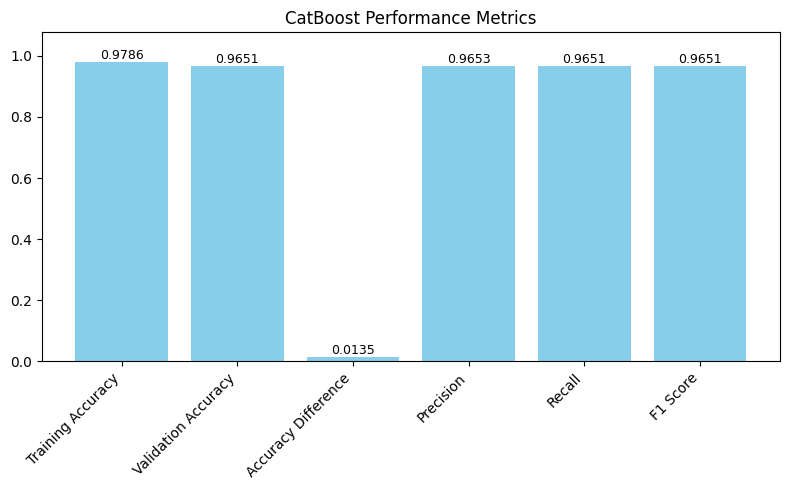


Evaluating SoftVoting...
Using stored KFold metrics for SoftVoting (classification).

 Evaluation for: SoftVoting
Training Accuracy  : 0.9762
Validation Accuracy: 0.9651
Accuracy Difference: 0.0111
Precision          : 0.9653
Recall             : 0.9651
F1 Score           : 0.9651



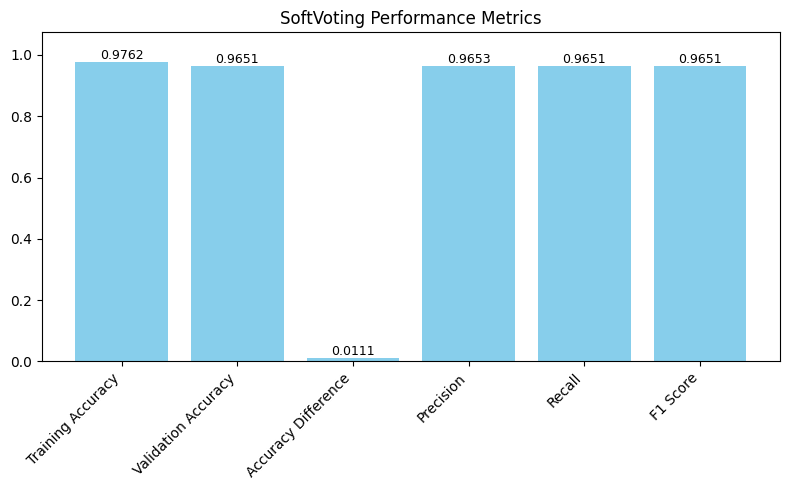


Evaluating hardVoting...
Using stored KFold metrics for hardVoting (classification).

 Evaluation for: hardVoting
Training Accuracy  : 0.9769
Validation Accuracy: 0.9656
Accuracy Difference: 0.0113
Precision          : 0.9658
Recall             : 0.9656
F1 Score           : 0.9656



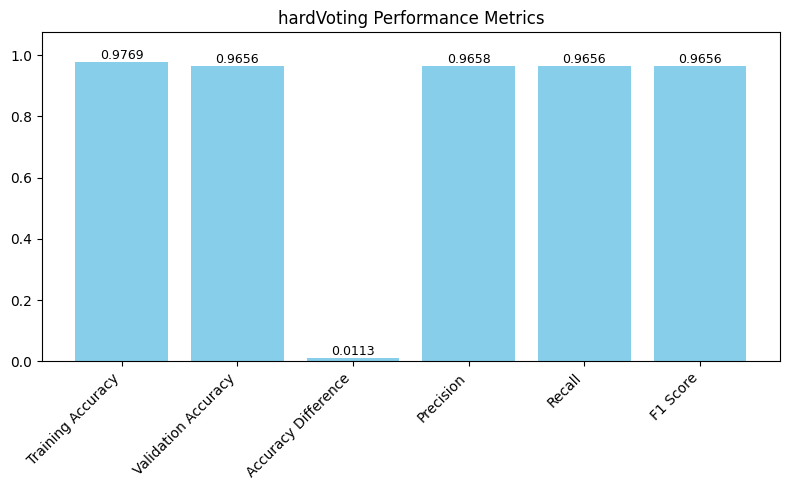

In [ ]:
classification_model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

Plotting train_accuracy comparison...


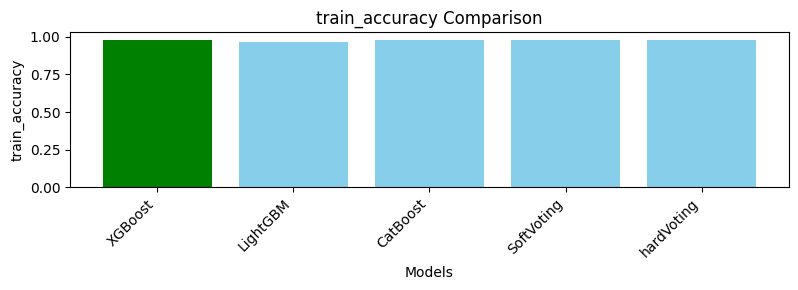

Plotting val_accuracy comparison...


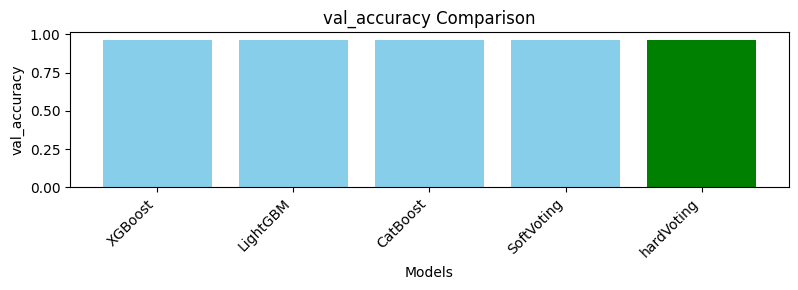

Plotting accuracy_diff comparison...


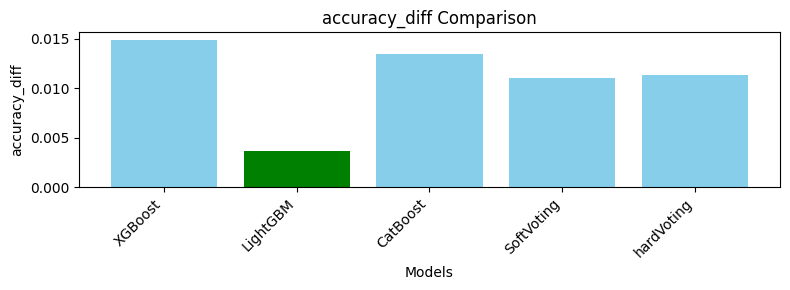

Plotting precision comparison...


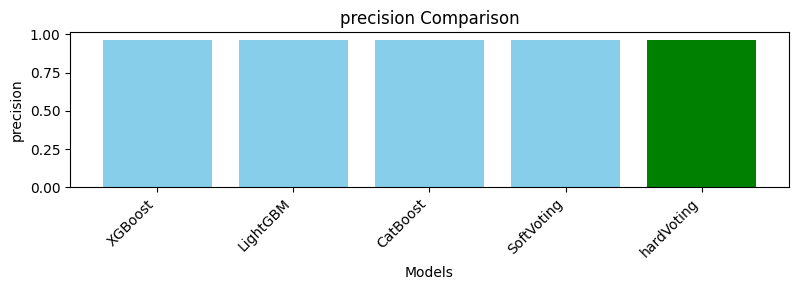

Plotting recall comparison...


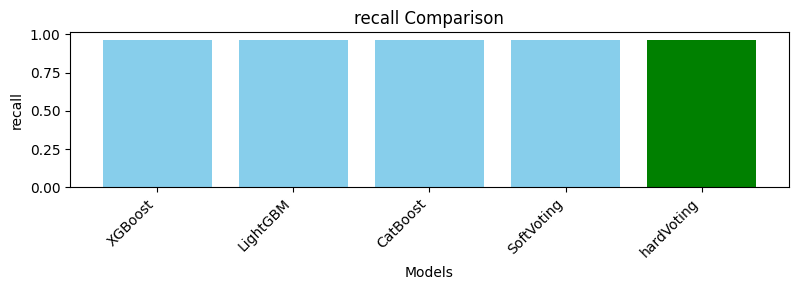

Plotting f1 comparison...


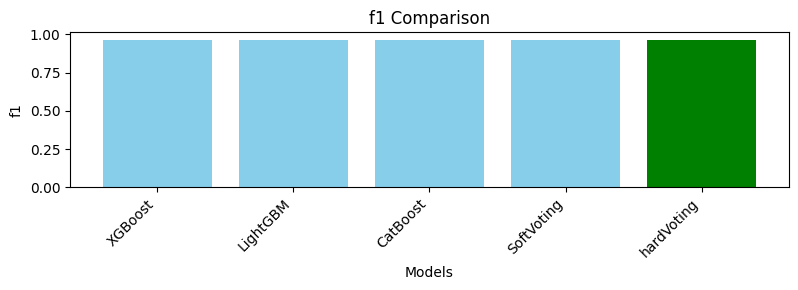

In [ ]:
classification_model_manager.plot_all_metrics()

## Experiment 3: fine tune it


In [ ]:
tuner = TuningManager({
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(verbosity=-1),
    'CatBoost': CatBoostClassifier(logging_level='Silent')
})

In [ ]:
hard_vote_study = tuner.tune_hard_voting_classification(50)

[I 2025-01-01 15:35:23,528] A new study created in memory with name: hard_voting_tuner
[I 2025-01-01 15:37:56,490] Trial 0 finished with value: 0.9629863324532252 and parameters: {'xgb_n_estimators': 500, 'xgb_max_depth': 6, 'xgb_lr': 0.001564175388758297, 'lgbm_n_estimators': 900, 'lgbm_num_leaves': 31, 'catb_depth': 4, 'catb_iters': 700, 'weight_xgb': 0.5587009833370424, 'weight_lgbm': 0.7673290455060555, 'weight_catb': 1.1579176752755187}. Best is trial 0 with value: 0.9629863324532252.
[I 2025-01-01 15:40:39,216] Trial 1 finished with value: 0.9688256932932259 and parameters: {'xgb_n_estimators': 300, 'xgb_max_depth': 8, 'xgb_lr': 0.009040816445984033, 'lgbm_n_estimators': 500, 'lgbm_num_leaves': 53, 'catb_depth': 7, 'catb_iters': 700, 'weight_xgb': 1.4068780067296225, 'weight_lgbm': 1.657211038428212, 'weight_catb': 0.7070532082702181}. Best is trial 1 with value: 0.9688256932932259.
[I 2025-01-01 15:43:14,664] Trial 2 finished with value: 0.963766288719542 and parameters: {'xgb_n

In [ ]:
tuner.plot_study(hard_vote_study)

In [ ]:
tuned_hard_vote = tuner.create_best_hard_vote_classification(hard_vote_study.best_trial.params)

In [ ]:
classification_model_manager.add_model('tuned_hard_vote', tuned_hard_vote, task='classification')

In [ ]:
classification_model_manager.train_model_KFold('tuned_hard_vote', x_train, y_train, task='classification')



Training model: tuned_hard_vote



Evaluating XGBoost...
Model : XGBoost
Training Accuracy  : 0.9799
Validation Accuracy: 0.9641
Accuracy Difference: 0.0158
Precision          : 0.9642
Recall             : 0.9641
F1 Score           : 0.9641

Confusion Matrix

                  Predicted
                  0       1
            0    11367      288
    Actual  1    468      8596
        


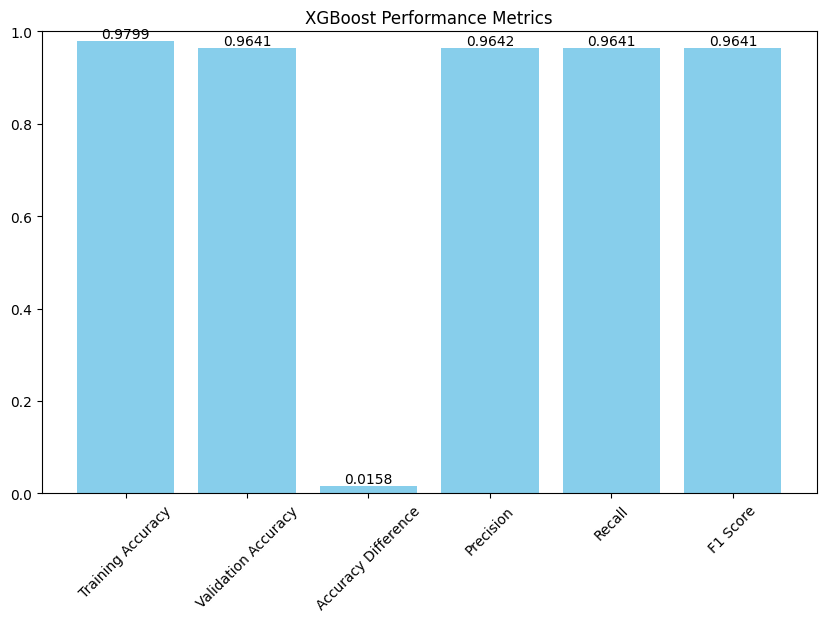


Evaluating LightGBM...
Model : LightGBM
Training Accuracy  : 0.9656
Validation Accuracy: 0.9619
Accuracy Difference: 0.0036
Precision          : 0.9623
Recall             : 0.9619
F1 Score           : 0.9619

Confusion Matrix

                  Predicted
                  0       1
            0    11407      248
    Actual  1    479      8585
        


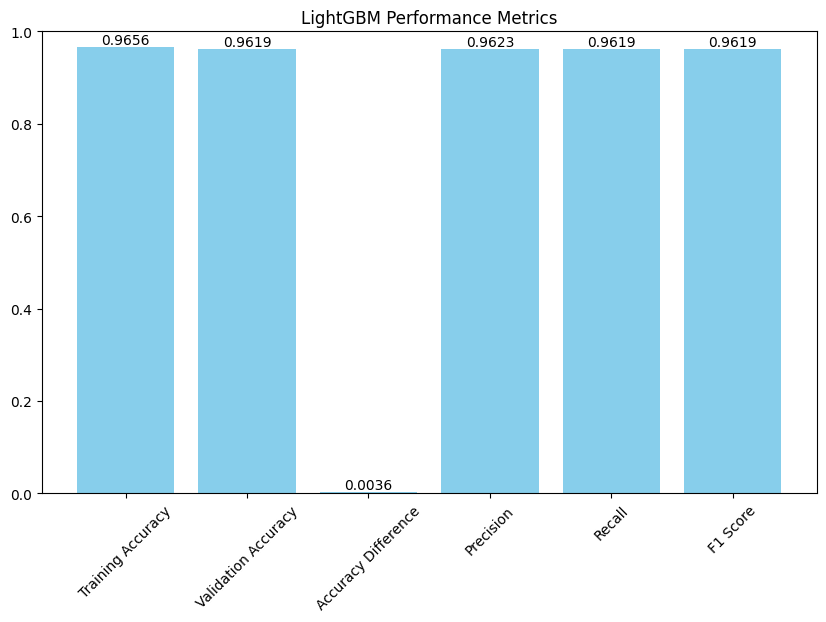


Evaluating CatBoost...
Model : CatBoost
Training Accuracy  : 0.9786
Validation Accuracy: 0.9650
Accuracy Difference: 0.0136
Precision          : 0.9651
Recall             : 0.9650
F1 Score           : 0.9650

Confusion Matrix

                  Predicted
                  0       1
            0    11372      283
    Actual  1    459      8605
        


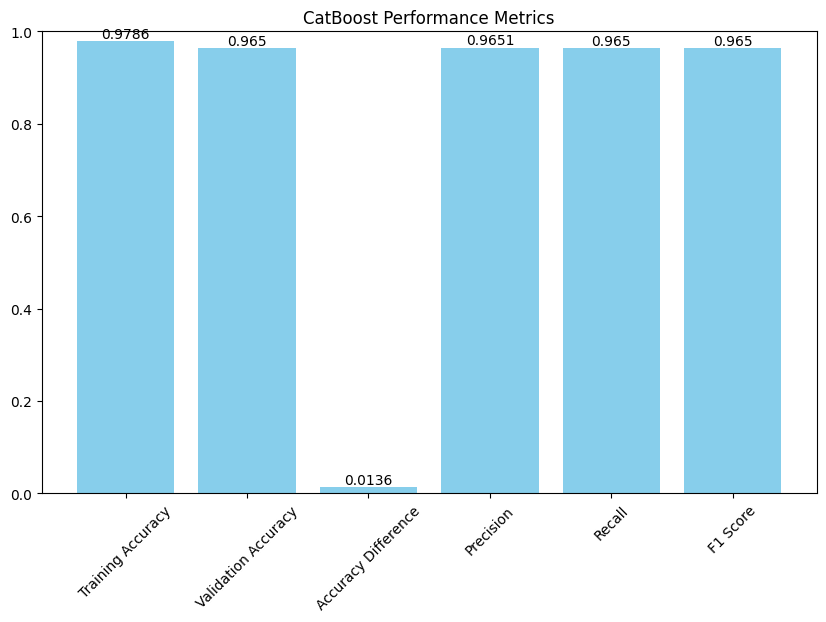


Evaluating SoftVoting...
Model : SoftVoting
Training Accuracy  : 0.9760
Validation Accuracy: 0.9651
Accuracy Difference: 0.0109
Precision          : 0.9653
Recall             : 0.9651
F1 Score           : 0.9651

Confusion Matrix

                  Predicted
                  0       1
            0    11409      246
    Actual  1    465      8599
        


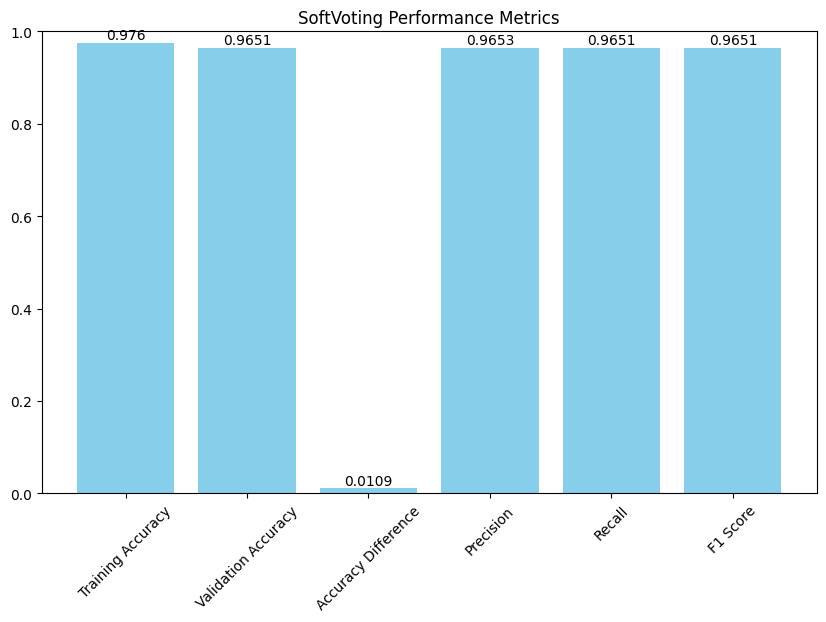


Evaluating hardVoting...
Model : hardVoting
Training Accuracy  : 0.9769
Validation Accuracy: 0.9652
Accuracy Difference: 0.0117
Precision          : 0.9654
Recall             : 0.9652
F1 Score           : 0.9652

Confusion Matrix

                  Predicted
                  0       1
            0    11401      254
    Actual  1    468      8596
        


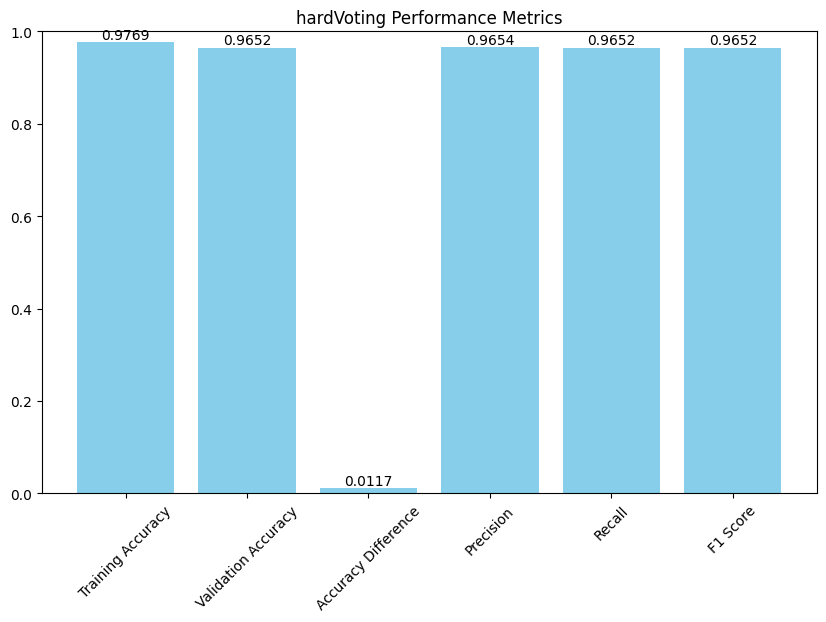


Evaluating tuned_hard_vote...
Model : tuned_hard_vote
Training Accuracy  : 0.9997
Validation Accuracy: 0.9713
Accuracy Difference: 0.0284
Precision          : 0.9714
Recall             : 0.9713
F1 Score           : 0.9713

Confusion Matrix

                  Predicted
                  0       1
            0    11436      219
    Actual  1    485      8579
        


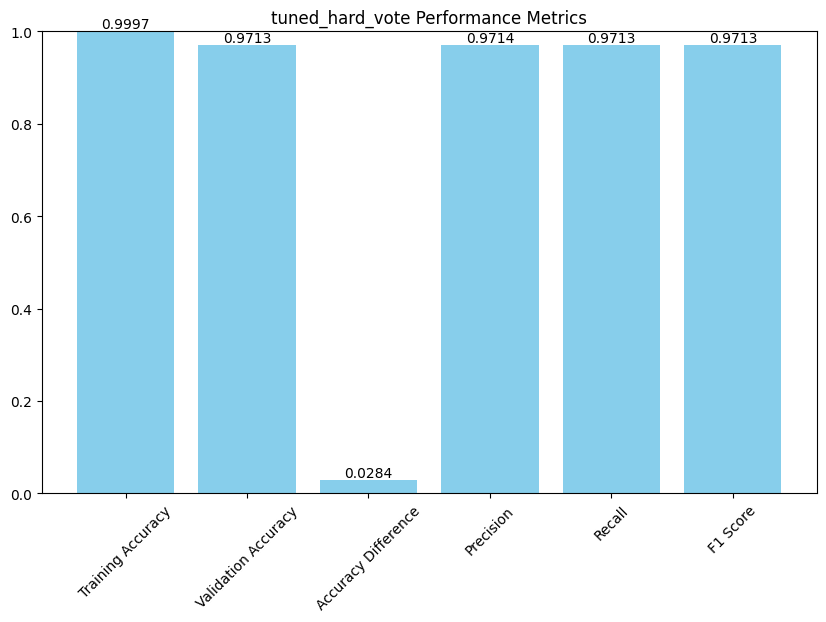

In [ ]:
classification_model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

Plotting train_accuracy comparison...


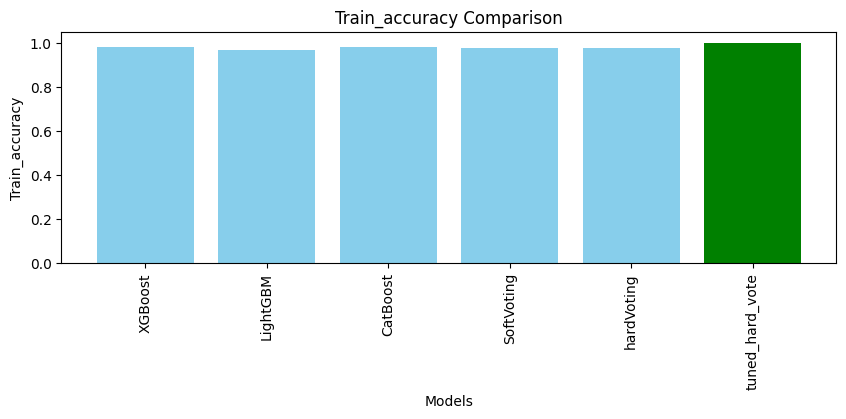

Plotting val_accuracy comparison...


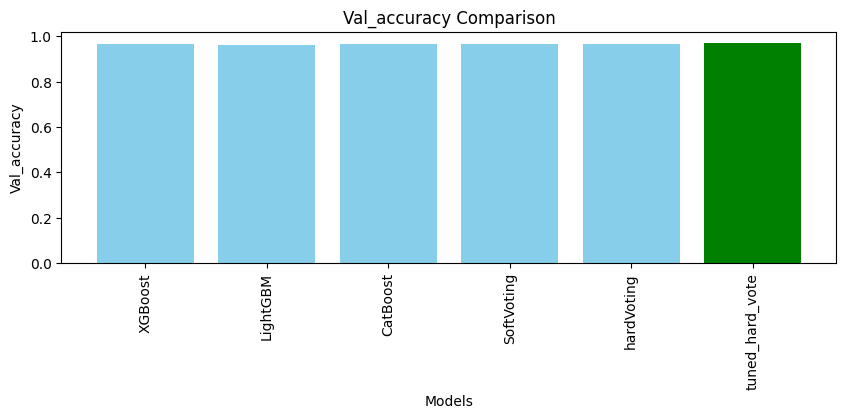

Plotting accuracy_diff comparison...


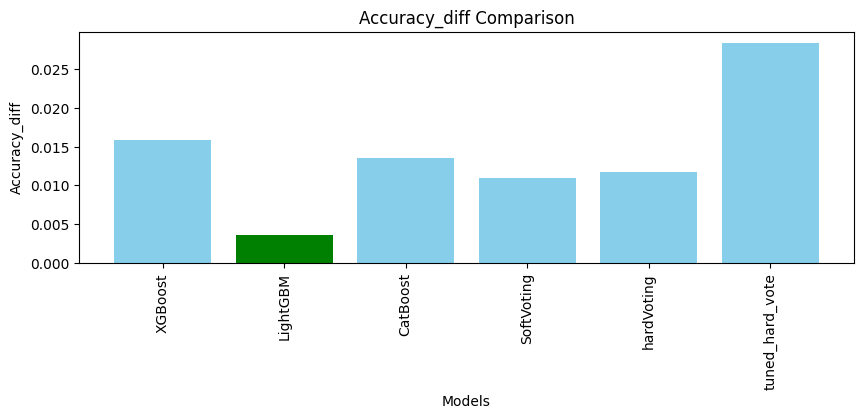

Plotting precision comparison...


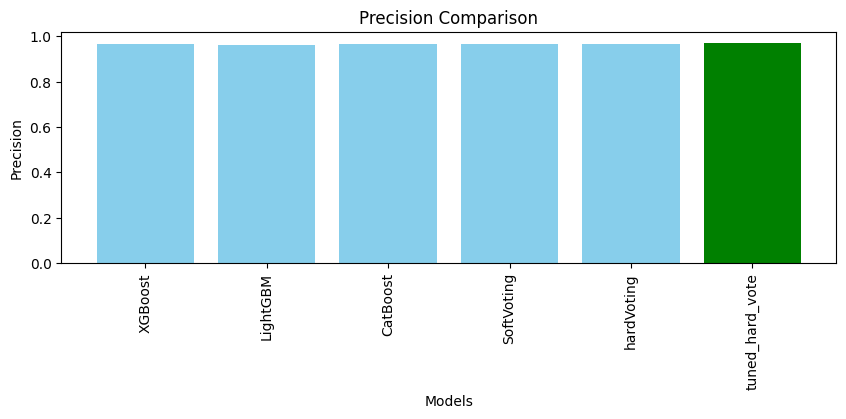

Plotting recall comparison...


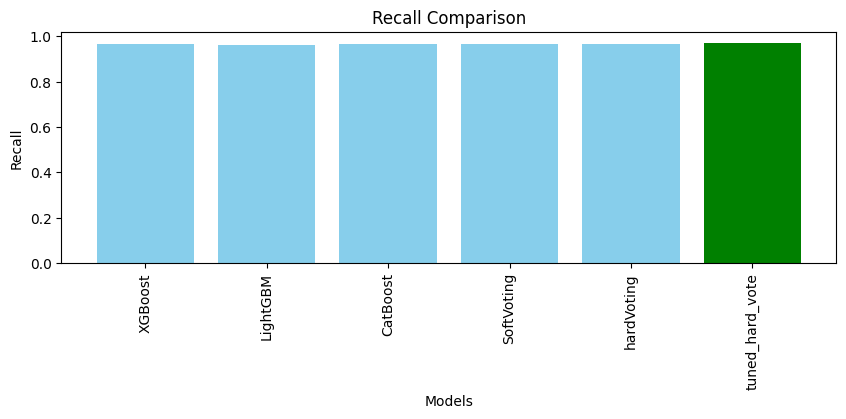

Plotting f1 comparison...


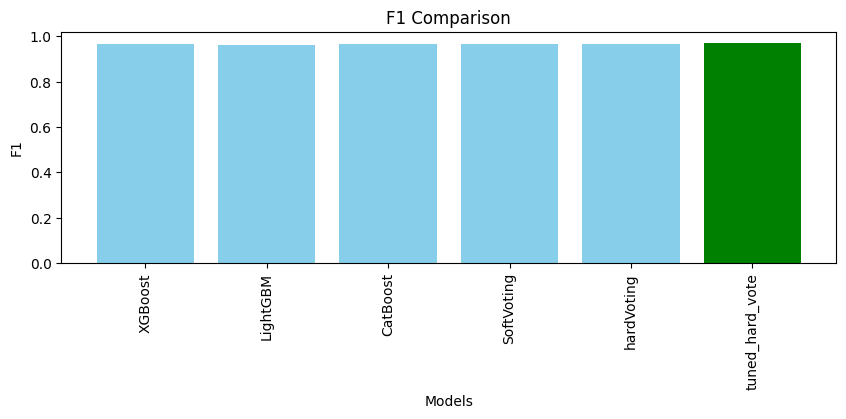

In [ ]:
classification_model_manager.plot_all_metrics()


# Problem 2

In [ ]:
import copy

reg_data_handler = copy.deepcopy(data_handler)

In [ ]:
reg_data_handler.drop_columns(['Gender','Customer Type','Type of Travel'])

Dropping columns: ['Gender', 'Customer Type', 'Type of Travel']


In [ ]:
x_train, x_test, y_train, y_test = reg_data_handler.split_data("log_DepartureDelayMinutes")

Data split into train and test sets.


## Experiment 1

In [ ]:
# Initialize the model manager
reg_model_manager = MultiTaskModelManager()

In [ ]:
# Add models to the manager
reg_model_manager.add_model('XGBoost', XGBRegressor(), task='regression')
reg_model_manager.add_model('LightGBM', LGBMRegressor(verbosity=-1), task='regression')
reg_model_manager.add_model('CatBoost', CatBoostRegressor(logging_level='Silent'), task='regression')

In [ ]:
# Train all models
reg_model_manager.train_all_models_KFold(x_train, y_train)


--- K-Fold (5) training for XGBoost (regression) ---

--- K-Fold (5) training for LightGBM (regression) ---

--- K-Fold (5) training for CatBoost (regression) ---



Evaluating XGBoost...
Using stored KFold metrics for XGBoost (regression).

 Evaluation for: XGBoost
Train MSE : 0.0000
Val MSE   : 0.0001
MSE diff  : -0.0001

Train MAE : 0.0005
Val MAE   : 0.0012
MAE diff  : -0.0007

Train R^2 : 1.0000
Val R^2   : 0.9999
R^2 diff  : 0.0001



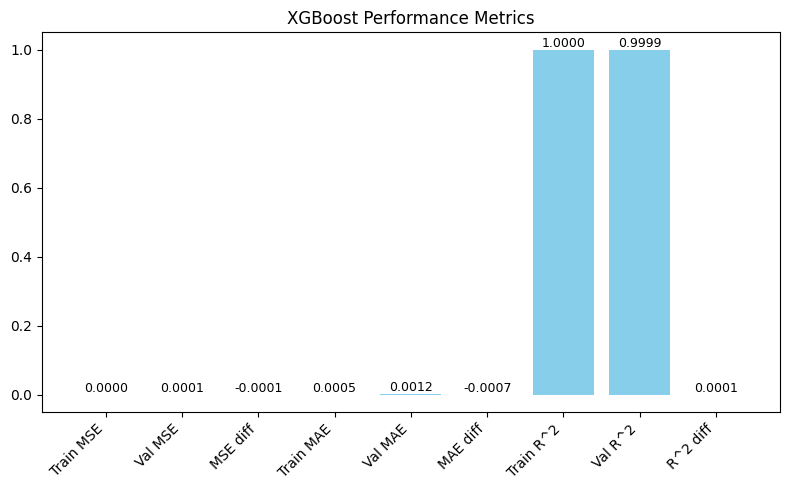


Evaluating LightGBM...
Using stored KFold metrics for LightGBM (regression).

 Evaluation for: LightGBM
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0002
Val MAE   : 0.0002
MAE diff  : -0.0000

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



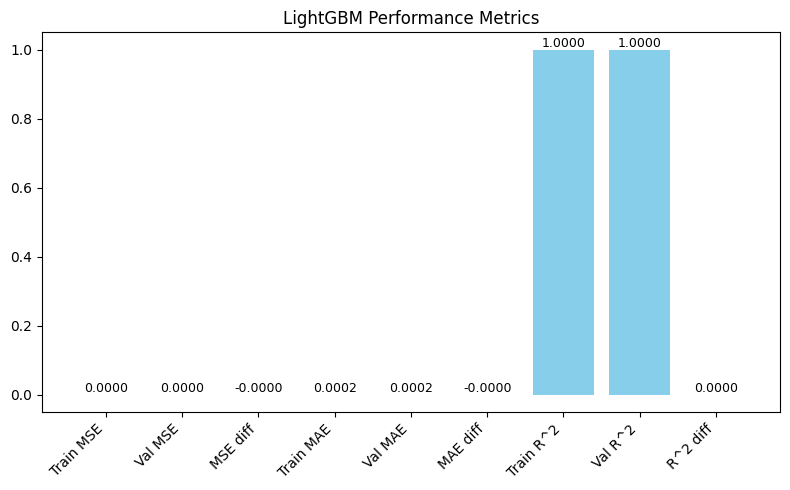


Evaluating CatBoost...
Using stored KFold metrics for CatBoost (regression).

 Evaluation for: CatBoost
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0008
Val MAE   : 0.0010
MAE diff  : -0.0001

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



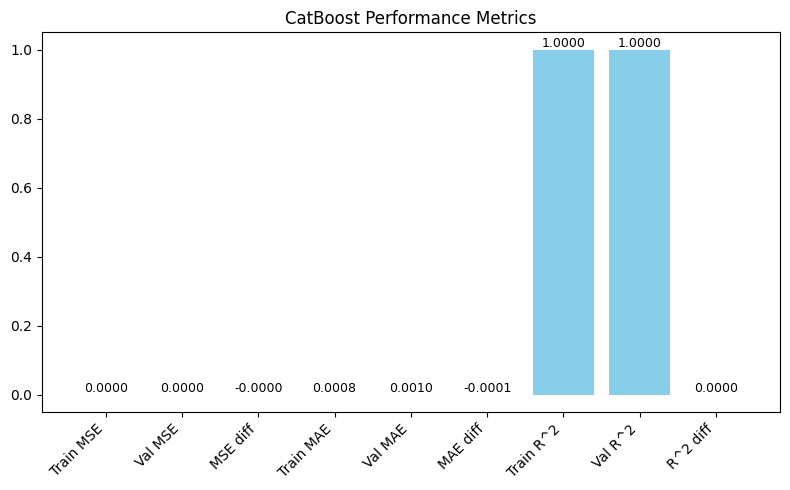

In [ ]:
# Evaluate all models
reg_model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

Plotting train_mse comparison...


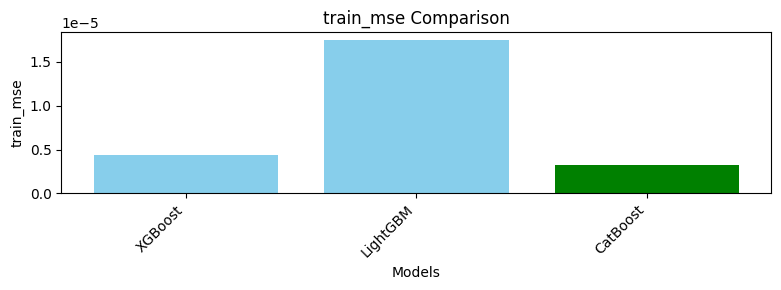

Plotting val_mse comparison...


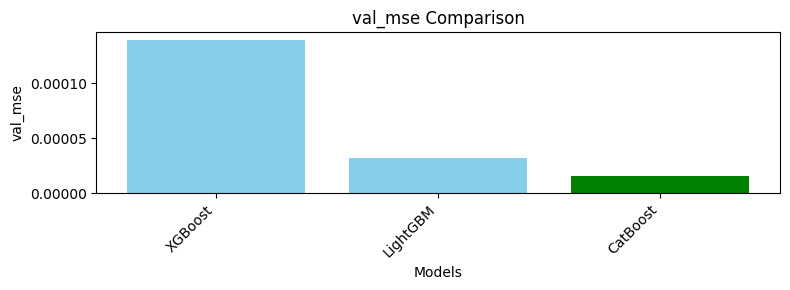

Plotting mse_diff comparison...


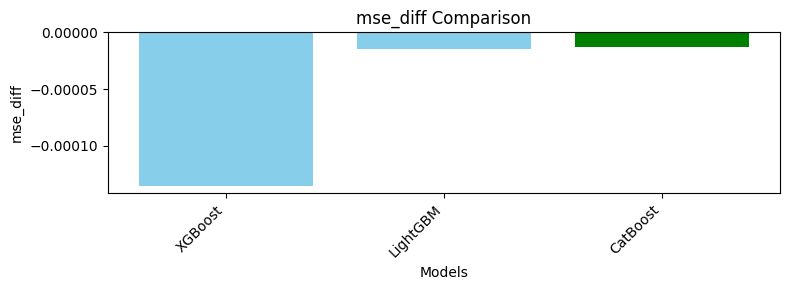

Plotting train_mae comparison...


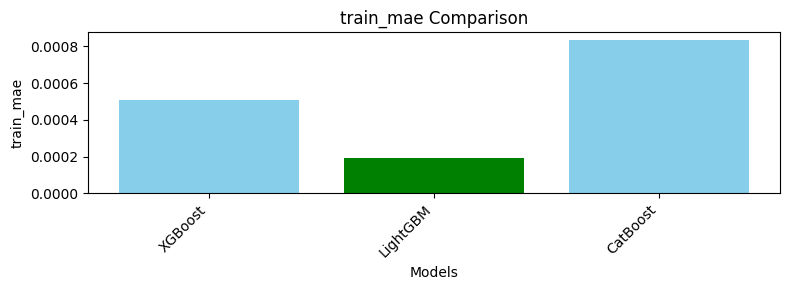

Plotting val_mae comparison...


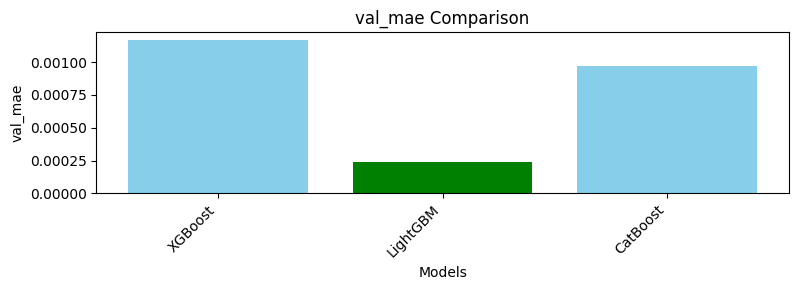

Plotting mae_diff comparison...


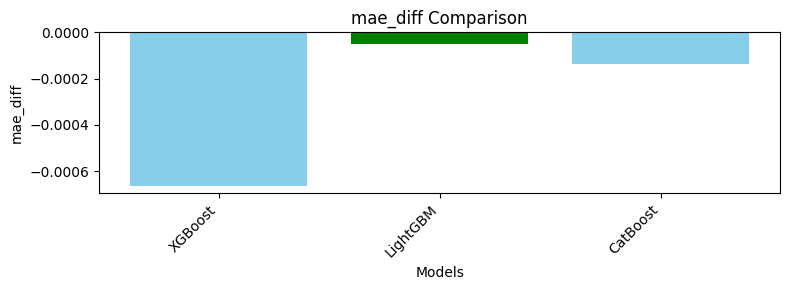

Plotting train_r2 comparison...


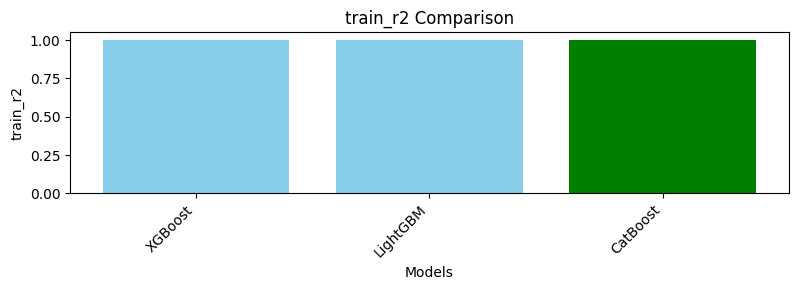

Plotting val_r2 comparison...


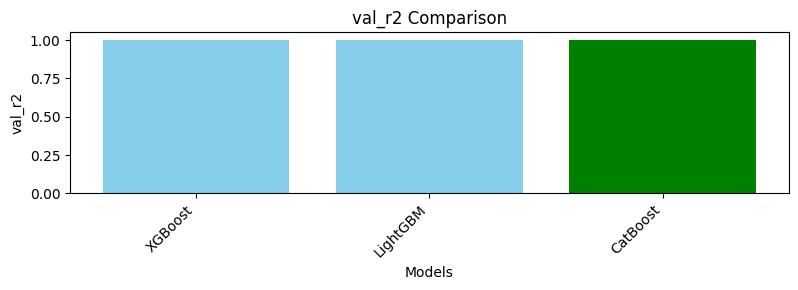

Plotting r2_diff comparison...


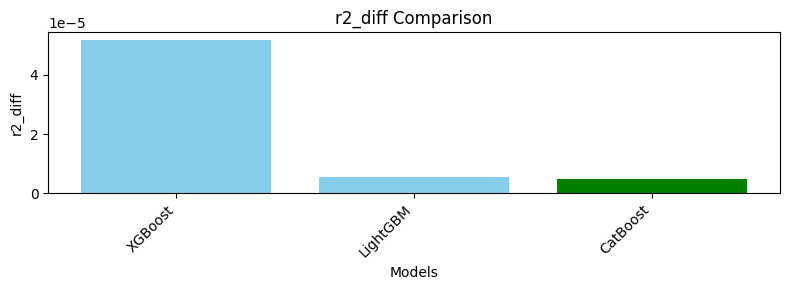

In [ ]:
reg_model_manager.plot_all_metrics()

## Experiment *2*

In [ ]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

# Retrieve your three models from reg_model_manager:
models = [
    ('XGBoost', reg_model_manager.get_all_models()['XGBoost']['model']),
    ('LightGBM', reg_model_manager.get_all_models()['LightGBM']['model']),
    ('CatBoost', reg_model_manager.get_all_models()['CatBoost']['model'])
]

# VotingRegressor for all three
voting_reg = VotingRegressor(estimators=models)
reg_model_manager.add_model('VotingReg_XGB_LGBM_CatB', voting_reg, task='regression')

# If you only want two models in another VotingRegressor:
models2 = [
    ('LightGBM', reg_model_manager.get_all_models()['LightGBM']['model']),
    ('CatBoost', reg_model_manager.get_all_models()['CatBoost']['model'])
]

voting_reg2 = VotingRegressor(estimators=models2)
reg_model_manager.add_model('VotingReg_LGBM_CatB', voting_reg2, task='regression')


In [ ]:
reg_model_manager.models.keys()

dict_keys(['XGBoost', 'LightGBM', 'CatBoost', 'VotingReg_XGB_LGBM_CatB', 'VotingReg_LGBM_CatB'])

In [ ]:
# Train all models
reg_model_manager.train_all_models_KFold(x_train, y_train)


--- K-Fold (5) training for XGBoost (regression) ---

--- K-Fold (5) training for LightGBM (regression) ---

--- K-Fold (5) training for CatBoost (regression) ---

--- K-Fold (5) training for VotingReg_XGB_LGBM_CatB (regression) ---

--- K-Fold (5) training for VotingReg_LGBM_CatB (regression) ---



Evaluating XGBoost...
Using stored KFold metrics for XGBoost (regression).

 Evaluation for: XGBoost
Train MSE : 0.0000
Val MSE   : 0.0001
MSE diff  : -0.0001

Train MAE : 0.0005
Val MAE   : 0.0012
MAE diff  : -0.0007

Train R^2 : 1.0000
Val R^2   : 0.9999
R^2 diff  : 0.0001



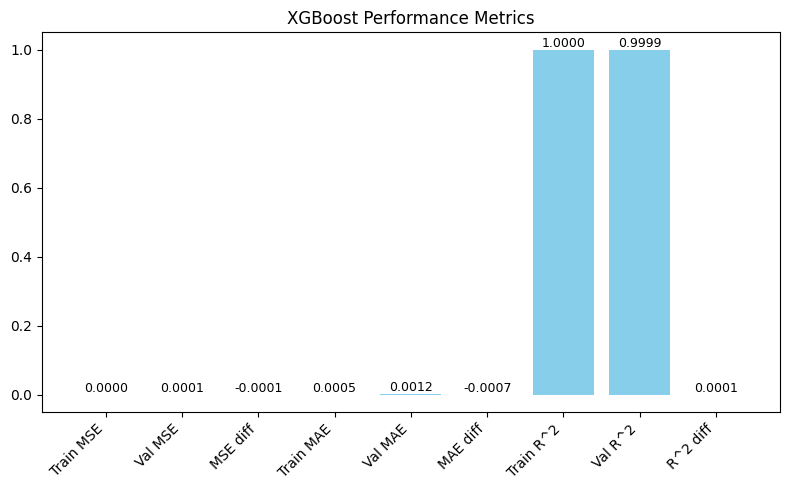


Evaluating LightGBM...
Using stored KFold metrics for LightGBM (regression).

 Evaluation for: LightGBM
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0002
Val MAE   : 0.0002
MAE diff  : -0.0000

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



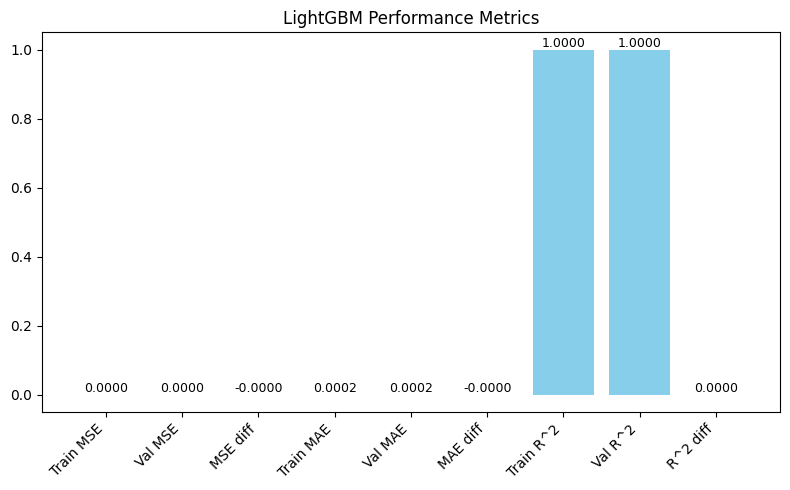


Evaluating CatBoost...
Using stored KFold metrics for CatBoost (regression).

 Evaluation for: CatBoost
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0008
Val MAE   : 0.0010
MAE diff  : -0.0001

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



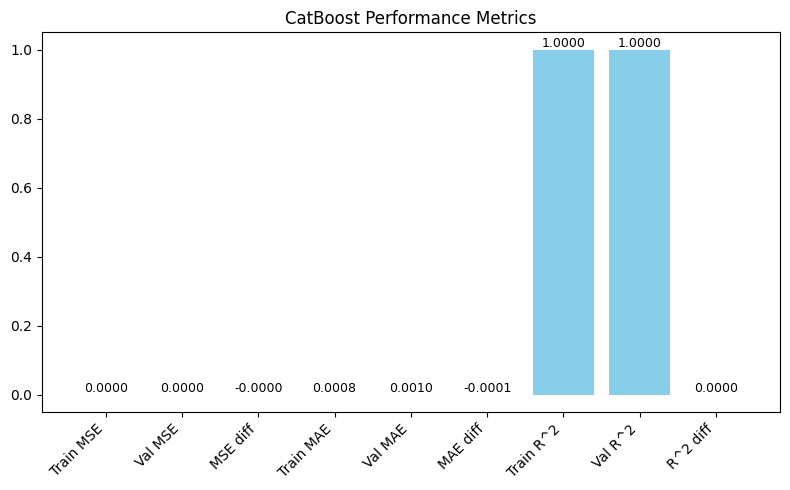


Evaluating VotingReg_XGB_LGBM_CatB...
Using stored KFold metrics for VotingReg_XGB_LGBM_CatB (regression).

 Evaluation for: VotingReg_XGB_LGBM_CatB
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0004
Val MAE   : 0.0006
MAE diff  : -0.0002

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



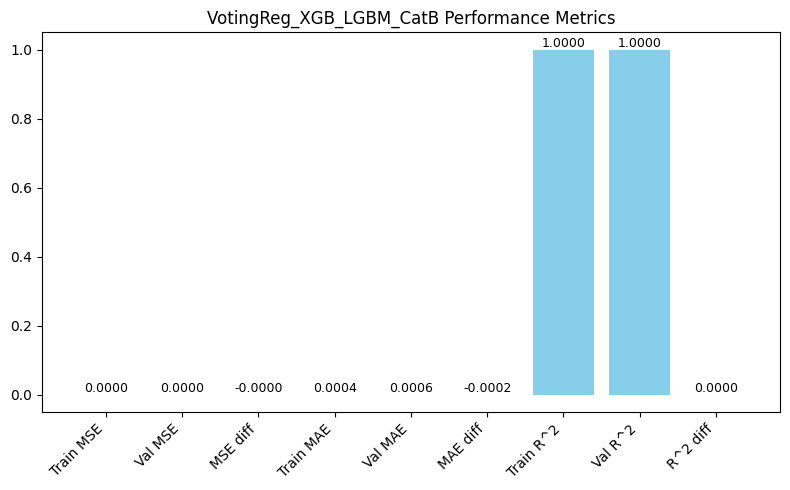


Evaluating VotingReg_LGBM_CatB...
Using stored KFold metrics for VotingReg_LGBM_CatB (regression).

 Evaluation for: VotingReg_LGBM_CatB
Train MSE : 0.0000
Val MSE   : 0.0000
MSE diff  : -0.0000

Train MAE : 0.0005
Val MAE   : 0.0005
MAE diff  : -0.0001

Train R^2 : 1.0000
Val R^2   : 1.0000
R^2 diff  : 0.0000



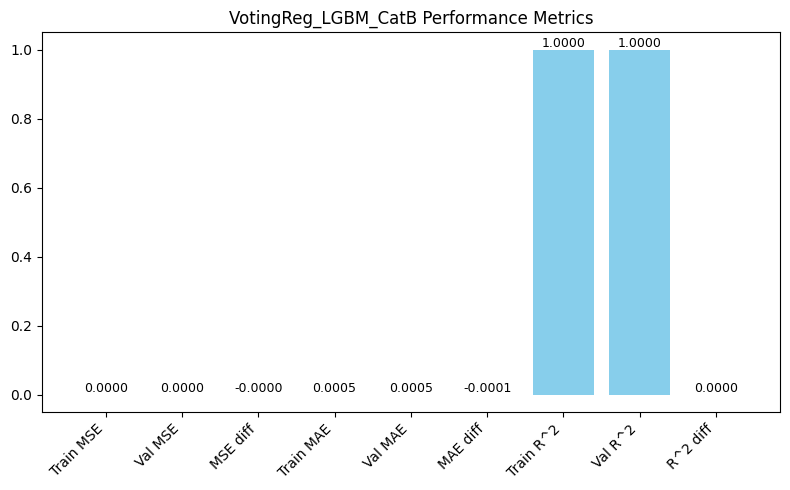

In [ ]:
# Evaluate all models
reg_model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

Plotting train_mse comparison...


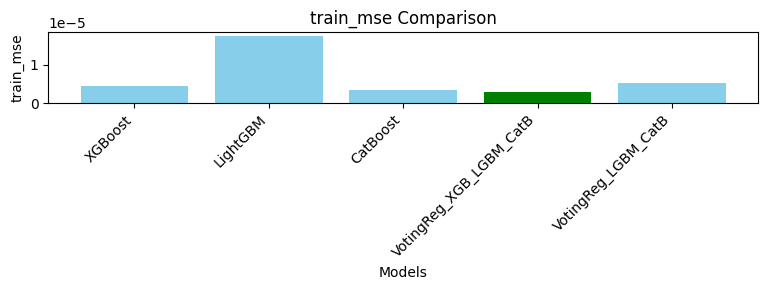

Plotting val_mse comparison...


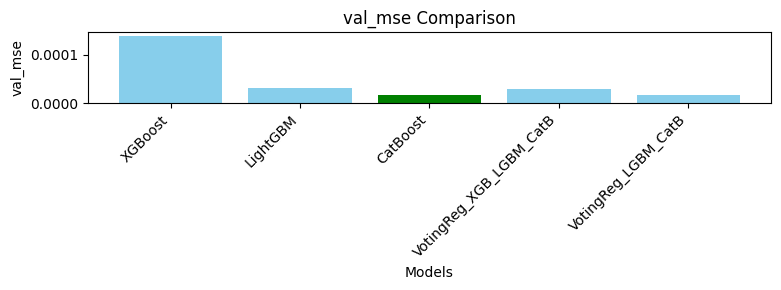

Plotting mse_diff comparison...


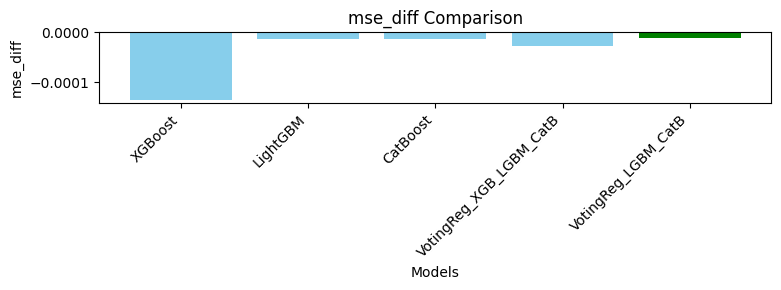

Plotting train_mae comparison...


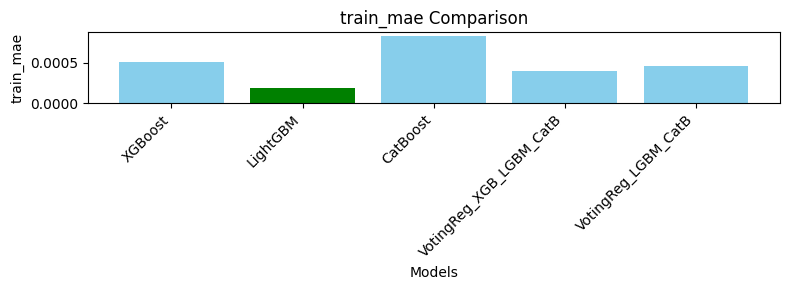

Plotting val_mae comparison...


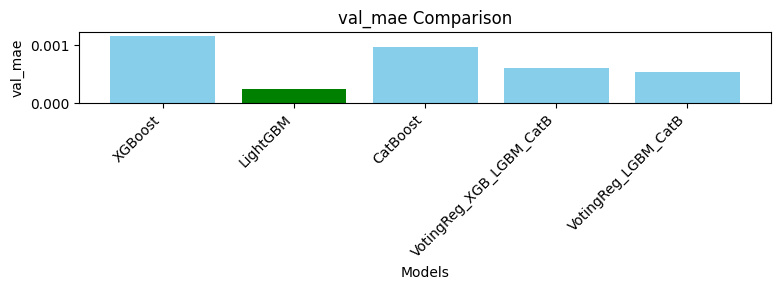

Plotting mae_diff comparison...


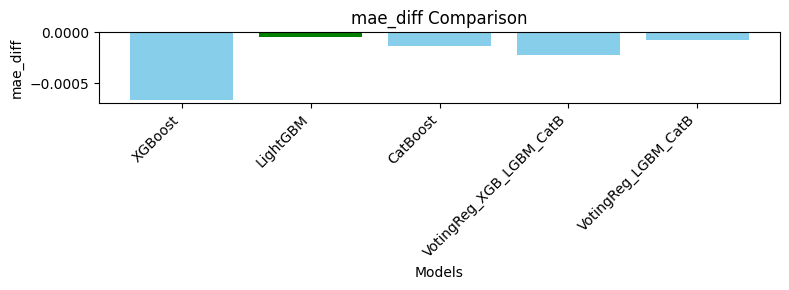

Plotting train_r2 comparison...


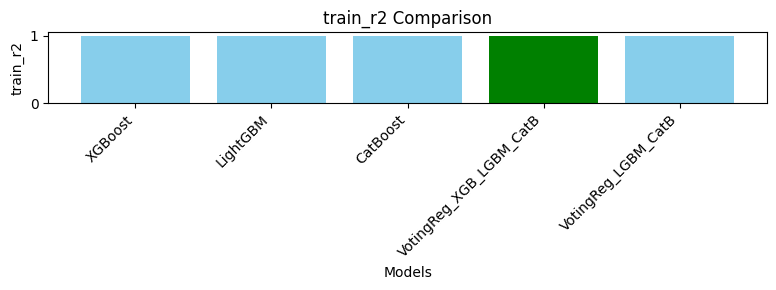

Plotting val_r2 comparison...


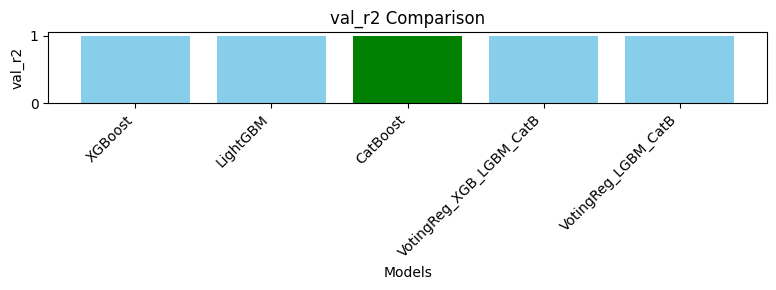

Plotting r2_diff comparison...


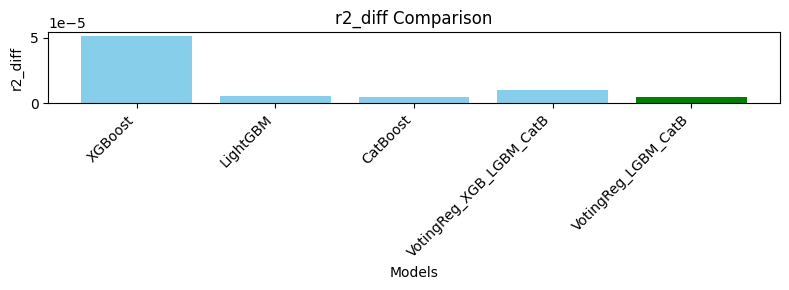

In [ ]:
reg_model_manager.plot_all_metrics()

# Problem 3

In [ ]:
import copy

cluster_data_handler = copy.deepcopy(data_handler)



In [ ]:
cluster_eda = EDA(cluster_data_handler.data)

In [ ]:
cluster_data_handler.drop_columns(['log_DepartureDelayMinutes','log_ArrivalDelayMinutes','Departure Delay in Minutes','Arrival Delay in Minutes','satisfaction'])

Dropping columns: ['log_DepartureDelayMinutes', 'log_ArrivalDelayMinutes', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


In [ ]:
cluster_data_handler.data.columns.tolist()

['Gender',
 'Customer Type',
 'Age',
 'Type of Travel',
 'Class',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [ ]:
def find_optimal_pca_components(X, variance_threshold=0.90):
    """
    Fits PCA on the data X and returns the smallest number of components
    needed to capture a given variance threshold.
    """
    pca_full = PCA()  # PCA without specifying n_components
    pca_full.fit(X)
    # Cumulative variance
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    # Smallest p that meets the threshold
    p_opt = np.argmax(cumulative_var >= variance_threshold) + 1

    return p_opt

def find_best_k_silhouette(X_pca, k_min=2, k_max=10):
    """
    Given PCA-transformed data X_pca, try KMeans for k in [k_min..k_max]
    and pick the k that yields the highest silhouette score.
    Returns (best_k, best_score).
    """
    best_score = -1
    best_k = None

    for k in range(k_min, k_max+1):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)

        if score > best_score:
            best_score = score
            best_k = k

    return best_k, best_score



In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(cluster_data_handler.data)


In [ ]:
cluster_data_handler.data.shape

(103594, 20)

## Experiment 1: dimensionality reduction + kmeans


In [ ]:
# Initialize the model manager
cluster_model_manager = MultiTaskModelManager()

In [ ]:
p_opt = find_optimal_pca_components(X)
print(f"Optimal number of components for 90% variance: {p_opt}")

Optimal number of components for 90% variance: 14


In [ ]:
pca = PCA(n_components=p_opt)
X_pca = pca.fit_transform(X)

In [ ]:
k_min = 2
k_max = 10
best_k, best_score = find_best_k_silhouette(X_pca, k_min, k_max)

KeyboardInterrupt: 

In [ ]:
best_k, best_score

(2, 0.1492905221981876)

In [ ]:
best_k, best_score = (2, 0.1492905221981876)

In [ ]:
cluster_model_manager.add_model(f'KMeans_{best_k}', KMeans(n_clusters=best_k), task='clustering')

In [ ]:
# Train all models
cluster_model_manager.train_all_models_KFold(X_pca,None)

K-Fold not applied for clustering model: KMeans_2.
KMeans_2 (clustering) trained successfully.


In [ ]:
cluster_model_manager.evaluate_all_models(None, None, X_pca, None)


Evaluating KMeans_2...

 Evaluation for: KMeans_2
Silhouette Score        : 0.1492791314952884
Calinski-Harabasz Score: 19331.703467627307
Davies-Bouldin Score    : 2.272915062258927



In [ ]:
kmeans_data = cluster_data_handler.data

In [ ]:
kmeans_data['ClusterLabel'] = cluster_model_manager.get_all_models()['KMeans_2']['model'].labels_


In [ ]:
# 8. Inspect the distribution of clusters
print(kmeans_data['ClusterLabel'].value_counts())

ClusterLabel
1    53879
0    49715
Name: count, dtype: int64


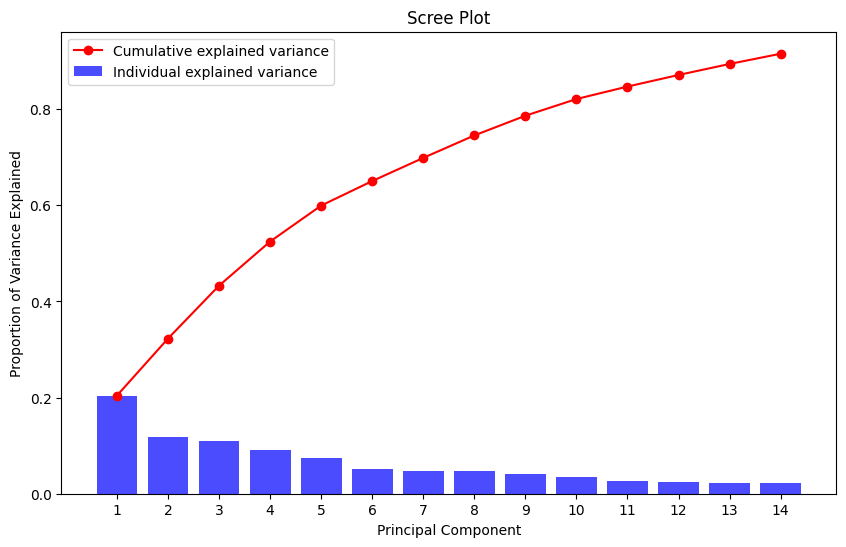

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pca = PCA(n_components=14)
# X_pca = pca.fit_transform(X)

# Explained variance ratio for each PC
evr = pca.explained_variance_ratio_

# Number of components
n_components = len(evr)

plt.figure(figsize=(10, 6))

# Bar chart for each PC’s explained variance
plt.bar(range(1, n_components + 1), evr, alpha=0.7, color='blue', label='Individual explained variance')

# Optionally, plot a cumulative line on top
plt.plot(range(1, n_components + 1), np.cumsum(evr), marker='o', color='red', label='Cumulative explained variance')

plt.xticks(range(1, n_components + 1))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.show()


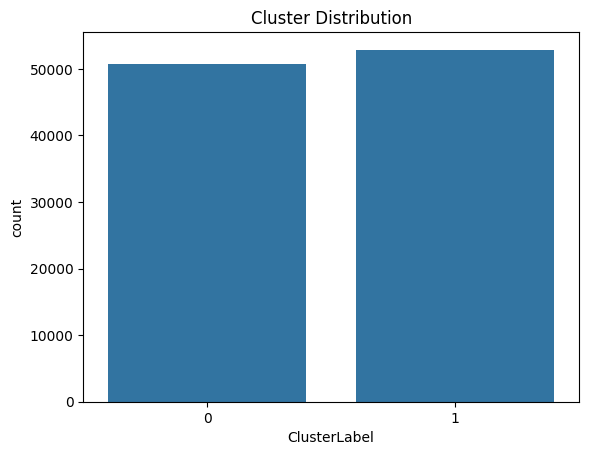

In [ ]:
import seaborn as sns

sns.countplot(x=kmeans_data["ClusterLabel"])
plt.title("Cluster Distribution")
plt.show()


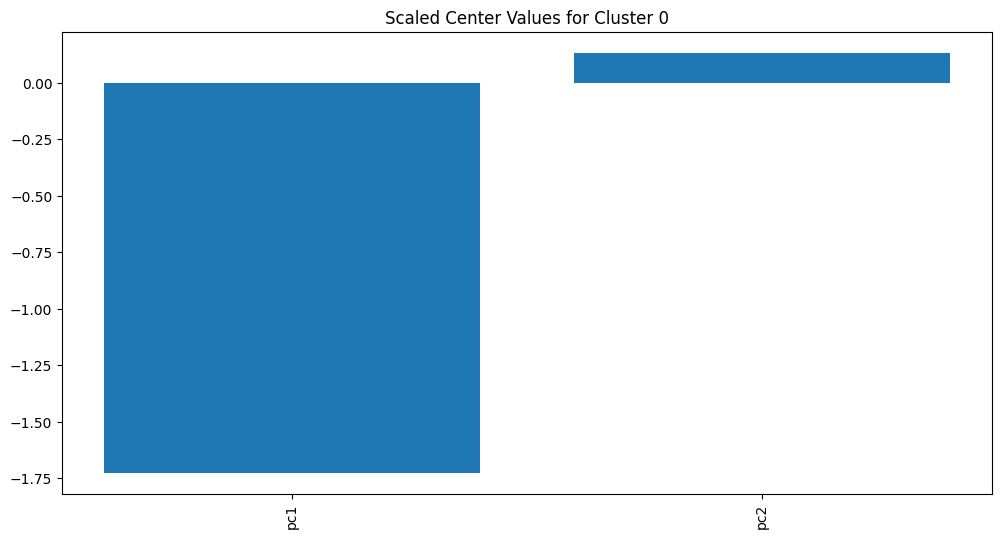

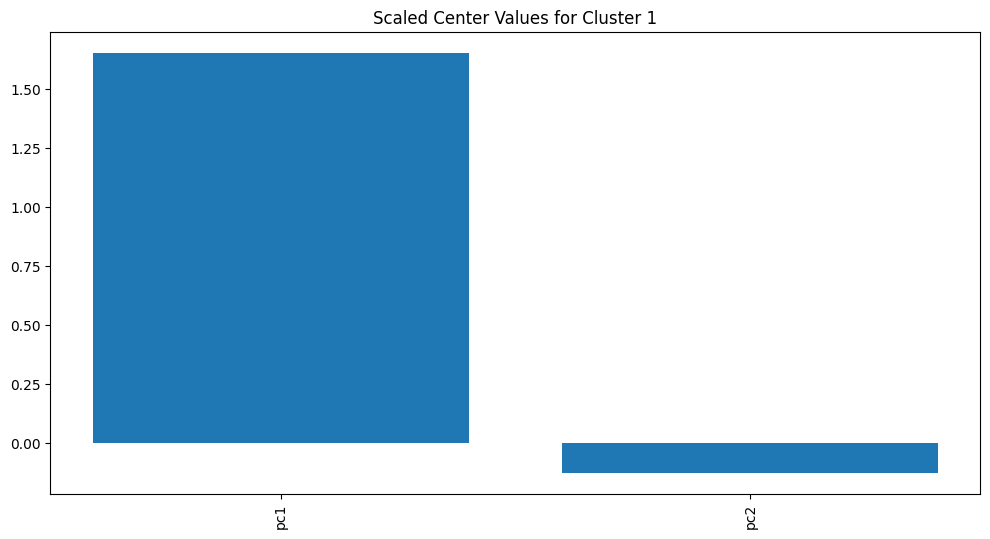

In [ ]:
import matplotlib.pyplot as plt

for cluster_idx in range(best_k):
  center_values = cluster_model_manager.get_all_models()['KMeans_2']['model'].cluster_centers_[cluster_idx]
  feature_names = cluster_data_handler.data.columns.tolist()[:-1]  # The columns you used for clustering

  plt.figure(figsize=(12, 6))
  plt.bar(range(len(center_values)), center_values)
  plt.xticks(range(len(center_values)), ['pc1','pc2'], rotation=90)
  plt.title(f"Scaled Center Values for Cluster {cluster_idx}")
  plt.show()


## Exp 2


In [ ]:
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')

In [ ]:
dbscan.fit(X)


DBSCAN()

In [ ]:
dbscan_data = cluster_data_handler.data

In [ ]:
dbscan_data['ClusterLabel'] = dbscan.labels_

In [ ]:
# 8. Inspect the distribution of clusters
print(dbscan_data['ClusterLabel'].value_counts())

ClusterLabel
-1    103547
 0         6
 3         6
 7         5
 4         5
 1         5
 2         5
 8         5
 5         5
 6         5
Name: count, dtype: int64


In [ ]:
temp = X

if len(set( dbscan.labels_)) > 1 and -1 in  dbscan.labels_:
    mask = ( dbscan.labels_ != -1)
    X_valid = temp[mask]
    labels_valid =  dbscan.labels_[mask]

    sil_dbscan = silhouette_score(X_valid, labels_valid)
    ch_dbscan = calinski_harabasz_score(X_valid, labels_valid)
    db_dbscan = davies_bouldin_score(X_valid, labels_valid)
else:
    sil_dbscan = silhouette_score(temp,  dbscan.labels_)
    ch_dbscan = calinski_harabasz_score(temp,  dbscan.labels_)
    db_dbscan = davies_bouldin_score(temp,  dbscan.labels_)

In [ ]:
print("Silhouette Score:       {:.5f}".format(sil_dbscan))
print("Calinski-Harabasz Score: {:.5f}".format(ch_dbscan))
print("Davies-Bouldin Score:   {:.5f}".format(db_dbscan))

Silhouette Score:       0.82388
Calinski-Harabasz Score: 442.87038
Davies-Bouldin Score:   0.22405


In [ ]:
df_no_outliers = dbscan_data[dbscan_data['ClusterLabel'] != -1].copy()

In [ ]:
cluster_counts = df_no_outliers['ClusterLabel'].value_counts().sort_index()
print("Number of points in each cluster (outliers removed):")
print(cluster_counts)
print("\n")


Number of points in each cluster (outliers removed):
ClusterLabel
0    6
1    5
2    5
3    6
4    5
5    5
6    5
7    5
8    5
Name: count, dtype: int64




In [ ]:
len(dbscan_data.columns.tolist()[:-1])

20

In [ ]:
print("Cluster-wise Means of Original Features (for interpretation):\n")
cluster_feature_summary = df_no_outliers.groupby('ClusterLabel')[dbscan_data.columns.tolist()[:-1]].mean()
cluster_feature_summary

Cluster-wise Means of Original Features (for interpretation):



,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
ClusterLabel,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,44.166667,1.0,2.0,634.833333,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0
1,0.0,1.0,43.400000,1.0,2.0,919.200000,1.0,1.0,1.0,1.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0
2,1.0,1.0,55.800000,1.0,2.0,557.400000,3.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,1.0,1.0,53.666667,1.0,2.0,2607.000000,1.0,1.0,1.0,1.0,2.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0
4,0.0,1.0,44.400000,1.0,2.0,1452.800000,1.0,1.0,1.0,1.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
5,0.0,1.0,41.400000,1.0,2.0,407.400000,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0
6,1.0,1.0,54.600000,1.0,2.0,1109.600000,1.0,1.0,1.0,1.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0
7,0.0,1.0,46.000000,1.0,2.0,623.400000,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0
8,1.0,1.0,55.600000,1.0,2.0,452.600000,3.0,3.0,3.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,3.0


In [ ]:
# 1) Create a list of names corresponding to clusters 0–8
cluster_names_list = [
    "Mostly Satisfied Males with Minor Check-In Complaints",        # Cluster 0
    "Comfort-Loving Females Disliking Wi-Fi & Booking",             # Cluster 1
    "Moderately Satisfied Older Males",                            # Cluster 2
    "Long-Haul Male Travelers: Comfort-Focused, Hate Wi-Fi & Food", # Cluster 3
    "Females on Longer Flights: Love Comfort, Dislike Wi-Fi/Booking",  # Cluster 4
    "Short-Haul Younger Females: Very Satisfied Except Cleanliness",   # Cluster 5
    "Older Males: Low Wi-Fi Satisfaction, High Comfort Scores",     # Cluster 6
    "Tech-Savvy Females Who Love Convenience & Entertainment",      # Cluster 7
    "Older Short-Haul Males: Moderate Wi-Fi Needs"                  # Cluster 8
]

# 2) Add a new column in 'cluster_feature_summary' with these names
cluster_feature_summary["ClusterName"] = cluster_feature_summary.index.map(
    lambda c: cluster_names_list[c] if c in range(len(cluster_names_list)) else "Unknown Cluster"
)

# Show the updated DataFrame
cluster_feature_summary


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,ClusterName
ClusterLabel,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,44.166667,1.0,2.0,634.833333,4.0,4.0,4.0,4.0,...,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,Mostly Satisfied Males with Minor Check-In Com...
1,0.0,1.0,43.400000,1.0,2.0,919.200000,1.0,1.0,1.0,1.0,...,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,Comfort-Loving Females Disliking Wi-Fi & Booking
2,1.0,1.0,55.800000,1.0,2.0,557.400000,3.0,3.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Moderately Satisfied Older Males
3,1.0,1.0,53.666667,1.0,2.0,2607.000000,1.0,1.0,1.0,1.0,...,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,"Long-Haul Male Travelers: Comfort-Focused, Hat..."
4,0.0,1.0,44.400000,1.0,2.0,1452.800000,1.0,1.0,1.0,1.0,...,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,"Females on Longer Flights: Love Comfort, Disli..."
5,0.0,1.0,41.400000,1.0,2.0,407.400000,4.0,4.0,4.0,4.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,Short-Haul Younger Females: Very Satisfied Exc...
6,1.0,1.0,54.600000,1.0,2.0,1109.600000,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,"Older Males: Low Wi-Fi Satisfaction, High Comf..."
7,0.0,1.0,46.000000,1.0,2.0,623.400000,5.0,5.0,5.0,5.0,...,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,Tech-Savvy Females Who Love Convenience & Ente...
8,1.0,1.0,55.600000,1.0,2.0,452.600000,3.0,3.0,3.0,3.0,...,4.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,3.0,Older Short-Haul Males: Moderate Wi-Fi Needs


In [ ]:
print(cluster_feature_summary.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrl}
\toprule
 & Gender & Customer Type & Age & Type of Travel & Class & Flight Distance & Inflight wifi service & Departure/Arrival time convenient & Ease of Online booking & Gate location & Food and drink & Online boarding & Seat comfort & Inflight entertainment & On-board service & Leg room service & Baggage handling & Checkin service & Inflight service & Cleanliness & ClusterName \\
ClusterLabel &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 1.000000 & 1.000000 & 44.166667 & 1.000000 & 2.000000 & 634.833333 & 4.000000 & 4.000000 & 4.000000 & 4.000000 & 4.000000 & 5.000000 & 4.000000 & 5.000000 & 5.000000 & 5.000000 & 5.000000 & 3.000000 & 5.000000 & 4.000000 & Mostly Satisfied Males with Minor Check-In Complaints \\
1 & 0.000000 & 1.000000 & 43.400000 & 1.000000 & 2.000000 & 919.200000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 4.000000 & 4.000000 & 5.000000 & 5.000000 & 5.000000 & 5.000000 & 5.000000 & 3.000000 